In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [2]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [3]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop(['book_title', 'summary', 'img_url', 'img_path'], axis = 1, inplace = True)

books_publishers = books.groupby('publisher')['isbn'].count().sort_values(ascending=False)
for i in books_publishers[books_publishers > 20].index: # 20 말고 10으로 하면 오류가 남..
    books['publisher'][books['publisher'].str.contains(i)] = i

In [4]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [5]:
books['category_high'].value_counts()

fiction                                            39678
biography autobiography                             3326
history                                             1927
religion                                            1824
nonfiction                                          1427
                                                   ...  
buddhismus                                             1
heller jettero fictitious character                    1
persian gulf                                           1
procedure law                                          1
authors canadian english 20th century biography        1
Name: category_high, Length: 3270, dtype: int64

In [6]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [7]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [8]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     68092 non-null  int64  
 4   location_state    68092 non-null  int64  
 5   location_country  68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [9]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [10]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


## rating 테이블과 merge

In [11]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')


# 모델링

In [12]:
params_cat = {
    "task_type" : "GPU",
    "devices" : '0',
    "random_seed": SEED,
    'learning_rate': 0.04574578205475402, 
    'bagging_temperature': 0.12172958098369972, 
    'n_estimators': 8459, 
    'max_depth': 8, 
    'random_strength': 28, 
    'l2_leaf_reg': 1.6285455533915874e-05, 
    'min_child_samples': 18, 
    'max_bin': 441, 
    'od_type': 'Iter',
    "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
}

X_tr, X_val, y_tr, y_val = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2,random_state= SEED)

model = CatBoostRegressor(**params_cat)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=10,
    verbose=False,
)

cat_pred2 = model.predict(X_val)
log_score = rmse(y_val, cat_pred2)

print(log_score)

2.1386023882367997


In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
train_ratings.reset_index(drop = True, inplace = True)
train_ratings = train_ratings.reset_index()

folds = []
fold = 0
train_ratings['fold'] = fold
for _, valid_idx in skf.split(train_ratings, train_ratings['rating']):
    fold += 1
    train_ratings['fold'][train_ratings['index'].isin(valid_idx)] = fold
train_ratings.drop(['index'], axis = 1, inplace = True)
train_ratings['fold']

0         5
1         3
2         2
3         1
4         3
         ..
306790    1
306791    3
306792    4
306793    3
306794    4
Name: fold, Length: 306795, dtype: int64

In [15]:
random.seed(SEED)
cat_models={}

cat_features = list(range(1, 10))

def objective(trial):
    param = {
        "random_seed": SEED,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating', 'fold'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 4000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    cat_pred = model.predict(X_valid)
    log_score = rmse(y_valid, cat_pred)

    return log_score

for fold in range(1,11):
    print(f'===================================={fold}============================================')
    X_train = train_ratings[train_ratings['fold'] != fold].drop(['fold', 'rating'],axis = 1)
    X_valid = train_ratings[train_ratings['fold'] == fold].drop(['fold', 'rating'],axis = 1)
    y_train = train_ratings[train_ratings['fold'] != fold]['rating']
    y_valid = train_ratings[train_ratings['fold'] == fold]['rating']

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)


    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', devices = '0', random_state = SEED, objective = 'RMSE', cat_features = list(train_ratings.drop(['rating','fold'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================1============================================


[I 2022-11-03 05:07:28,461] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328872	test: 2.4328488	best: 2.4328488 (0)	total: 15.5ms	remaining: 49.4s
100:	learn: 2.4273810	test: 2.4258071	best: 2.4258071 (100)	total: 1.4s	remaining: 43s
200:	learn: 2.4273619	test: 2.4257088	best: 2.4257088 (200)	total: 2.77s	remaining: 41.2s
300:	learn: 2.4273615	test: 2.4257042	best: 2.4257041 (291)	total: 4.16s	remaining: 40s
bestTest = 2.425703788
bestIteration = 335
Shrink model to first 336 iterations.


[I 2022-11-03 05:07:35,838] Trial 0 finished with value: 2.4257039992899507 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4257039992899507.


0:	learn: 2.4331476	test: 2.4331493	best: 2.4331493 (0)	total: 14.7ms	remaining: 51.5s
100:	learn: 2.4292842	test: 2.4285398	best: 2.4285398 (100)	total: 1.36s	remaining: 45.7s
200:	learn: 2.4280011	test: 2.4268542	best: 2.4268542 (200)	total: 2.71s	remaining: 44.5s
300:	learn: 2.4275734	test: 2.4262058	best: 2.4262058 (300)	total: 4.09s	remaining: 43.4s
400:	learn: 2.4274320	test: 2.4259398	best: 2.4259398 (400)	total: 5.45s	remaining: 42.1s
500:	learn: 2.4273845	test: 2.4258220	best: 2.4258220 (500)	total: 6.8s	remaining: 40.7s
600:	learn: 2.4273696	test: 2.4257664	best: 2.4257664 (600)	total: 8.18s	remaining: 39.4s
700:	learn: 2.4273641	test: 2.4257378	best: 2.4257378 (700)	total: 9.53s	remaining: 38s
800:	learn: 2.4273628	test: 2.4257227	best: 2.4257227 (800)	total: 10.9s	remaining: 36.6s
900:	learn: 2.4273616	test: 2.4257144	best: 2.4257144 (900)	total: 12.2s	remaining: 35.2s
1000:	learn: 2.4273615	test: 2.4257102	best: 2.4257102 (998)	total: 13.6s	remaining: 33.8s
1100:	learn: 2.

[I 2022-11-03 05:08:26,302] Trial 1 finished with value: 2.4257041814253224 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4257039992899507.


0:	learn: 2.4097249	test: 2.4055871	best: 2.4055871 (0)	total: 29.7ms	remaining: 55.7s
100:	learn: 2.1874399	test: 2.1432943	best: 2.1432943 (100)	total: 2.81s	remaining: 49.5s
200:	learn: 2.1713752	test: 2.1352270	best: 2.1352270 (200)	total: 5.52s	remaining: 46s
300:	learn: 2.1550982	test: 2.1310451	best: 2.1310451 (300)	total: 7.96s	remaining: 41.7s
400:	learn: 2.1434072	test: 2.1292016	best: 2.1291557 (395)	total: 10.5s	remaining: 38.5s
500:	learn: 2.1328843	test: 2.1285168	best: 2.1284557 (493)	total: 13.1s	remaining: 35.9s
600:	learn: 2.1232962	test: 2.1282944	best: 2.1282360 (592)	total: 15.7s	remaining: 33.3s
700:	learn: 2.1138556	test: 2.1275043	best: 2.1275043 (700)	total: 18.4s	remaining: 30.8s
800:	learn: 2.1051977	test: 2.1272040	best: 2.1271358 (778)	total: 21s	remaining: 28.2s
900:	learn: 2.0967249	test: 2.1275777	best: 2.1270339 (847)	total: 23.7s	remaining: 25.6s
1000:	learn: 2.0884786	test: 2.1276178	best: 2.1270339 (847)	total: 26.4s	remaining: 23s
1100:	learn: 2.080

[I 2022-11-03 05:09:18,506] Trial 2 finished with value: 2.1270338948851744 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.4089267	test: 2.4084855	best: 2.4084855 (0)	total: 459ms	remaining: 9m 7s
100:	learn: 2.0488371	test: 2.1400071	best: 2.1393196 (99)	total: 46.3s	remaining: 8m 21s
200:	learn: 1.8725893	test: 2.1399943	best: 2.1369671 (145)	total: 1m 32s	remaining: 7m 35s
300:	learn: 1.4403627	test: 2.1560433	best: 2.1369671 (145)	total: 2m 18s	remaining: 6m 51s
400:	learn: 1.1472628	test: 2.1752027	best: 2.1369671 (145)	total: 3m 4s	remaining: 6m 5s
500:	learn: 0.9600247	test: 2.1885204	best: 2.1369671 (145)	total: 3m 50s	remaining: 5m 19s
600:	learn: 0.8169833	test: 2.1965624	best: 2.1369671 (145)	total: 4m 36s	remaining: 4m 33s
700:	learn: 0.7076610	test: 2.2027997	best: 2.1369671 (145)	total: 5m 22s	remaining: 3m 47s
800:	learn: 0.6143144	test: 2.2088019	best: 2.1369671 (145)	total: 6m 8s	remaining: 3m 1s
900:	learn: 0.5362104	test: 2.2136872	best: 2.1369671 (145)	total: 6m 54s	remaining: 2m 15s
1000:	learn: 0.4774224	test: 2.2167411	best: 2.1369671 (145)	total: 7m 40s	remaining: 1m 29s

[I 2022-11-03 05:18:33,308] Trial 3 finished with value: 2.136967019977751 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.4300486	test: 2.4299179	best: 2.4299179 (0)	total: 245ms	remaining: 4m 29s
100:	learn: 2.2586044	test: 2.2472764	best: 2.2472764 (100)	total: 24.7s	remaining: 4m 4s
200:	learn: 2.1881208	test: 2.1811871	best: 2.1811871 (200)	total: 49.3s	remaining: 3m 41s
300:	learn: 2.1522071	test: 2.1570770	best: 2.1570770 (300)	total: 1m 14s	remaining: 3m 17s
400:	learn: 2.1276450	test: 2.1456109	best: 2.1456109 (400)	total: 1m 39s	remaining: 2m 53s
500:	learn: 2.1068550	test: 2.1394578	best: 2.1394578 (500)	total: 2m 4s	remaining: 2m 29s
600:	learn: 2.0903526	test: 2.1357149	best: 2.1357121 (599)	total: 2m 28s	remaining: 2m 4s
700:	learn: 2.0758098	test: 2.1332583	best: 2.1332583 (700)	total: 2m 53s	remaining: 1m 39s
800:	learn: 2.0622769	test: 2.1315380	best: 2.1315380 (800)	total: 3m 18s	remaining: 1m 15s
900:	learn: 2.0471250	test: 2.1300646	best: 2.1300646 (900)	total: 3m 43s	remaining: 50.2s
1000:	learn: 2.0339677	test: 2.1291071	best: 2.1291071 (1000)	total: 4m 8s	remaining: 25.3s

[I 2022-11-03 05:23:15,627] Trial 4 finished with value: 2.1281021234541746 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.4024278	test: 2.4075956	best: 2.4075956 (0)	total: 241ms	remaining: 15m 19s
bestTest = 2.255274696
bestIteration = 34
Shrink model to first 35 iterations.


[I 2022-11-03 05:23:31,516] Trial 5 finished with value: 2.2552746288173724 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.4243072	test: 2.4227494	best: 2.4227494 (0)	total: 27.7ms	remaining: 1m 36s
100:	learn: 2.2111379	test: 2.1659215	best: 2.1659215 (100)	total: 2.52s	remaining: 1m 24s
200:	learn: 2.1919609	test: 2.1455869	best: 2.1455869 (200)	total: 5.08s	remaining: 1m 23s
300:	learn: 2.1848438	test: 2.1400278	best: 2.1400278 (300)	total: 7.66s	remaining: 1m 21s
400:	learn: 2.1797946	test: 2.1373158	best: 2.1373158 (400)	total: 10.3s	remaining: 1m 18s
500:	learn: 2.1742918	test: 2.1348101	best: 2.1348101 (500)	total: 12.7s	remaining: 1m 15s
600:	learn: 2.1670875	test: 2.1323505	best: 2.1323505 (600)	total: 14.9s	remaining: 1m 11s
700:	learn: 2.1606804	test: 2.1306796	best: 2.1306796 (700)	total: 17.2s	remaining: 1m 8s
800:	learn: 2.1556011	test: 2.1298131	best: 2.1298131 (800)	total: 19.5s	remaining: 1m 5s
900:	learn: 2.1509835	test: 2.1290604	best: 2.1290586 (899)	total: 21.8s	remaining: 1m 2s
1000:	learn: 2.1467877	test: 2.1283956	best: 2.1283956 (1000)	total: 24.2s	remaining: 1m
bestTes

[I 2022-11-03 05:24:01,966] Trial 6 finished with value: 2.128141191883557 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.3773209	test: 2.3694286	best: 2.3694286 (0)	total: 144ms	remaining: 2m 26s
100:	learn: 1.9930613	test: 2.1447297	best: 2.1396706 (64)	total: 14.7s	remaining: 2m 13s
200:	learn: 1.5788468	test: 2.1800188	best: 2.1396706 (64)	total: 29.1s	remaining: 1m 58s
300:	learn: 1.3096213	test: 2.2050735	best: 2.1396706 (64)	total: 43.3s	remaining: 1m 42s
400:	learn: 1.1132496	test: 2.2243365	best: 2.1396706 (64)	total: 57.6s	remaining: 1m 28s
500:	learn: 0.9338683	test: 2.2431626	best: 2.1396706 (64)	total: 1m 11s	remaining: 1m 13s
600:	learn: 0.7851201	test: 2.2535133	best: 2.1396706 (64)	total: 1m 26s	remaining: 59.7s
700:	learn: 0.6822179	test: 2.2629438	best: 2.1396706 (64)	total: 1m 41s	remaining: 45.5s
800:	learn: 0.6034078	test: 2.2698278	best: 2.1396706 (64)	total: 1m 55s	remaining: 31.1s
900:	learn: 0.5343646	test: 2.2743954	best: 2.1396706 (64)	total: 2m 10s	remaining: 16.6s
1000:	learn: 0.4751580	test: 2.2790637	best: 2.1396706 (64)	total: 2m 25s	remaining: 2.18s
1015:	learn

[I 2022-11-03 05:26:33,338] Trial 7 finished with value: 2.1396706378449264 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.3713194	test: 2.3585954	best: 2.3585954 (0)	total: 14.1ms	remaining: 28s
100:	learn: 2.2006553	test: 2.1536041	best: 2.1535989 (99)	total: 1.68s	remaining: 31.5s
200:	learn: 2.1959008	test: 2.1515542	best: 2.1515422 (198)	total: 3.43s	remaining: 30.6s
300:	learn: 2.1923077	test: 2.1503678	best: 2.1503264 (293)	total: 5.23s	remaining: 29.4s
400:	learn: 2.1891288	test: 2.1494154	best: 2.1494044 (393)	total: 7.02s	remaining: 27.9s
500:	learn: 2.1861175	test: 2.1477298	best: 2.1476933 (476)	total: 8.72s	remaining: 26s
600:	learn: 2.1836658	test: 2.1473130	best: 2.1472520 (582)	total: 10.2s	remaining: 23.6s
700:	learn: 2.1809981	test: 2.1456027	best: 2.1456027 (700)	total: 11.7s	remaining: 21.6s
800:	learn: 2.1790871	test: 2.1451274	best: 2.1451274 (800)	total: 13.2s	remaining: 19.6s
900:	learn: 2.1774175	test: 2.1450195	best: 2.1449844 (894)	total: 14.7s	remaining: 17.8s
1000:	learn: 2.1754261	test: 2.1444770	best: 2.1444425 (998)	total: 16.1s	remaining: 16s
1100:	learn: 2.1734

[I 2022-11-03 05:27:07,583] Trial 8 finished with value: 2.142278630624866 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.4311171	test: 2.4310546	best: 2.4310546 (0)	total: 39.3ms	remaining: 2m 8s
100:	learn: 2.3137928	test: 2.3055880	best: 2.3055880 (100)	total: 3.98s	remaining: 2m 5s
200:	learn: 2.2662329	test: 2.2585547	best: 2.2585547 (200)	total: 7.85s	remaining: 2m
300:	learn: 2.2392928	test: 2.2343876	best: 2.2343876 (300)	total: 11.8s	remaining: 1m 56s
400:	learn: 2.2227897	test: 2.2229153	best: 2.2229153 (400)	total: 15.7s	remaining: 1m 52s
500:	learn: 2.2097054	test: 2.2147293	best: 2.2147293 (500)	total: 19.7s	remaining: 1m 49s
600:	learn: 2.1980941	test: 2.2089393	best: 2.2089393 (600)	total: 23.5s	remaining: 1m 44s
700:	learn: 2.1874300	test: 2.2035563	best: 2.2035563 (700)	total: 27.4s	remaining: 1m 40s
800:	learn: 2.1780216	test: 2.1997609	best: 2.1997609 (800)	total: 31.2s	remaining: 1m 36s
900:	learn: 2.1689925	test: 2.1961526	best: 2.1961526 (900)	total: 35.2s	remaining: 1m 33s
1000:	learn: 2.1612944	test: 2.1940597	best: 2.1940597 (1000)	total: 39.2s	remaining: 1m 29s
1100:	

[I 2022-11-03 05:28:33,800] Trial 9 finished with value: 2.1804243530651464 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1270338948851744.


0:	learn: 2.4097249	total: 27ms	remaining: 50.7s
1:	learn: 2.3877602	total: 50.9ms	remaining: 47.7s
2:	learn: 2.3676476	total: 74.9ms	remaining: 46.7s
3:	learn: 2.3504533	total: 99.6ms	remaining: 46.6s
4:	learn: 2.3355215	total: 123ms	remaining: 45.9s
5:	learn: 2.3224294	total: 150ms	remaining: 46.6s
6:	learn: 2.3108200	total: 172ms	remaining: 45.9s
7:	learn: 2.3017885	total: 196ms	remaining: 45.8s
8:	learn: 2.2921871	total: 222ms	remaining: 46s
9:	learn: 2.2843989	total: 246ms	remaining: 46s
10:	learn: 2.2780347	total: 272ms	remaining: 46.1s
11:	learn: 2.2706996	total: 299ms	remaining: 46.4s
12:	learn: 2.2649150	total: 326ms	remaining: 46.7s
13:	learn: 2.2617121	total: 351ms	remaining: 46.6s
14:	learn: 2.2592895	total: 378ms	remaining: 46.9s
15:	learn: 2.2553017	total: 402ms	remaining: 46.7s
16:	learn: 2.2511059	total: 429ms	remaining: 46.9s
17:	learn: 2.2489320	total: 458ms	remaining: 47.2s
18:	learn: 2.2453128	total: 486ms	remaining: 47.5s
19:	learn: 2.2422466	total: 512ms	remaining

[I 2022-11-03 05:29:25,573] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328913	test: 2.4326600	best: 2.4326600 (0)	total: 13.9ms	remaining: 44.5s
100:	learn: 2.4270869	test: 2.4259033	best: 2.4259033 (100)	total: 1.3s	remaining: 39.8s
200:	learn: 2.4270673	test: 2.4258373	best: 2.4258373 (200)	total: 2.58s	remaining: 38.5s
bestTest = 2.425834692
bestIteration = 264
Shrink model to first 265 iterations.


[I 2022-11-03 05:29:31,821] Trial 0 finished with value: 2.4258348869403314 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4258348869403314.


0:	learn: 2.4331652	test: 2.4329602	best: 2.4329602 (0)	total: 15.2ms	remaining: 53.2s
100:	learn: 2.4290938	test: 2.4284122	best: 2.4284122 (100)	total: 1.35s	remaining: 45.5s
200:	learn: 2.4277404	test: 2.4268115	best: 2.4268115 (200)	total: 2.65s	remaining: 43.4s
300:	learn: 2.4272911	test: 2.4262283	best: 2.4262283 (300)	total: 3.91s	remaining: 41.6s
400:	learn: 2.4271416	test: 2.4260054	best: 2.4260054 (400)	total: 5.19s	remaining: 40.1s
500:	learn: 2.4270923	test: 2.4259140	best: 2.4259140 (500)	total: 6.42s	remaining: 38.4s
600:	learn: 2.4270757	test: 2.4258741	best: 2.4258741 (600)	total: 7.71s	remaining: 37.1s
700:	learn: 2.4270704	test: 2.4258553	best: 2.4258553 (700)	total: 8.92s	remaining: 35.6s
800:	learn: 2.4270682	test: 2.4258457	best: 2.4258457 (800)	total: 10.2s	remaining: 34.3s
900:	learn: 2.4270678	test: 2.4258406	best: 2.4258406 (896)	total: 11.6s	remaining: 33.3s
1000:	learn: 2.4270676	test: 2.4258377	best: 2.4258377 (1000)	total: 12.8s	remaining: 32s
1100:	learn: 

[I 2022-11-03 05:30:21,266] Trial 1 finished with value: 2.425834732736287 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.425834732736287.


0:	learn: 2.4098287	test: 2.4067193	best: 2.4067193 (0)	total: 29ms	remaining: 54.4s
100:	learn: 2.1870137	test: 2.1504357	best: 2.1504357 (100)	total: 2.8s	remaining: 49.2s
200:	learn: 2.1710717	test: 2.1427044	best: 2.1427044 (200)	total: 5.39s	remaining: 44.9s
300:	learn: 2.1541974	test: 2.1376994	best: 2.1376412 (298)	total: 7.73s	remaining: 40.4s
400:	learn: 2.1426613	test: 2.1363675	best: 2.1362863 (396)	total: 10.2s	remaining: 37.5s
500:	learn: 2.1313678	test: 2.1351789	best: 2.1351688 (499)	total: 12.7s	remaining: 34.9s
600:	learn: 2.1213786	test: 2.1345869	best: 2.1344428 (581)	total: 15.2s	remaining: 32.1s
700:	learn: 2.1115794	test: 2.1347218	best: 2.1344428 (581)	total: 17.6s	remaining: 29.4s
800:	learn: 2.1028663	test: 2.1346498	best: 2.1344194 (752)	total: 20s	remaining: 26.8s
900:	learn: 2.0935918	test: 2.1345589	best: 2.1344194 (752)	total: 22.4s	remaining: 24.2s
1000:	learn: 2.0851161	test: 2.1346550	best: 2.1344194 (752)	total: 24.9s	remaining: 21.8s
1100:	learn: 2.07

[I 2022-11-03 05:31:12,144] Trial 2 finished with value: 2.134191069718517 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134191069718517.


0:	learn: 2.4083877	test: 2.4091222	best: 2.4091222 (0)	total: 460ms	remaining: 9m 9s
100:	learn: 2.0332562	test: 2.1488839	best: 2.1488696 (99)	total: 46.3s	remaining: 8m 21s
200:	learn: 1.8517007	test: 2.1481718	best: 2.1457434 (169)	total: 1m 32s	remaining: 7m 36s
300:	learn: 1.4023065	test: 2.1766428	best: 2.1457434 (169)	total: 2m 19s	remaining: 6m 54s
400:	learn: 1.1390604	test: 2.1965153	best: 2.1457434 (169)	total: 3m 6s	remaining: 6m 9s
500:	learn: 0.9566754	test: 2.2069580	best: 2.1457434 (169)	total: 3m 53s	remaining: 5m 22s
600:	learn: 0.8154470	test: 2.2149810	best: 2.1457434 (169)	total: 4m 39s	remaining: 4m 36s
700:	learn: 0.7087701	test: 2.2201134	best: 2.1457434 (169)	total: 5m 26s	remaining: 3m 49s
800:	learn: 0.6156674	test: 2.2241650	best: 2.1457434 (169)	total: 6m 12s	remaining: 3m 3s
900:	learn: 0.5437674	test: 2.2282210	best: 2.1457434 (169)	total: 6m 58s	remaining: 2m 16s
1000:	learn: 0.4796812	test: 2.2308853	best: 2.1457434 (169)	total: 7m 44s	remaining: 1m 29

[I 2022-11-03 05:40:30,876] Trial 3 finished with value: 2.145743453932879 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134191069718517.


0:	learn: 2.4299445	test: 2.4297458	best: 2.4297458 (0)	total: 245ms	remaining: 4m 29s
100:	learn: 2.2559085	test: 2.2522602	best: 2.2522602 (100)	total: 25.1s	remaining: 4m 9s
200:	learn: 2.1833890	test: 2.1897136	best: 2.1897136 (200)	total: 49.9s	remaining: 3m 44s
300:	learn: 2.1461790	test: 2.1660068	best: 2.1660068 (300)	total: 1m 15s	remaining: 3m 20s
400:	learn: 2.1211476	test: 2.1551149	best: 2.1551149 (400)	total: 1m 39s	remaining: 2m 54s
500:	learn: 2.1008865	test: 2.1491305	best: 2.1491305 (500)	total: 2m 5s	remaining: 2m 30s
600:	learn: 2.0820601	test: 2.1451180	best: 2.1451180 (600)	total: 2m 30s	remaining: 2m 5s
700:	learn: 2.0660951	test: 2.1426052	best: 2.1426052 (700)	total: 2m 55s	remaining: 1m 40s
800:	learn: 2.0502366	test: 2.1410907	best: 2.1410907 (800)	total: 3m 19s	remaining: 1m 15s
900:	learn: 2.0342866	test: 2.1397214	best: 2.1397214 (900)	total: 3m 44s	remaining: 50.3s
1000:	learn: 2.0196776	test: 2.1386948	best: 2.1386948 (1000)	total: 4m 9s	remaining: 25.5s

[I 2022-11-03 05:45:15,230] Trial 4 finished with value: 2.1378608516790916 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134191069718517.


0:	learn: 2.3924266	test: 2.4053307	best: 2.4053307 (0)	total: 244ms	remaining: 15m 30s
bestTest = 2.278526341
bestIteration = 11
Shrink model to first 12 iterations.


[I 2022-11-03 05:45:25,582] Trial 5 finished with value: 2.278526417072051 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.134191069718517.


0:	learn: 2.4243361	test: 2.4228591	best: 2.4228591 (0)	total: 29.8ms	remaining: 1m 43s
100:	learn: 2.2114755	test: 2.1745743	best: 2.1745743 (100)	total: 2.78s	remaining: 1m 33s
200:	learn: 2.1918223	test: 2.1532876	best: 2.1532876 (200)	total: 5.63s	remaining: 1m 32s
300:	learn: 2.1846057	test: 2.1477234	best: 2.1477234 (300)	total: 8.59s	remaining: 1m 30s
400:	learn: 2.1795177	test: 2.1446524	best: 2.1446524 (400)	total: 11.5s	remaining: 1m 28s
500:	learn: 2.1739968	test: 2.1419601	best: 2.1419601 (500)	total: 14.2s	remaining: 1m 24s
600:	learn: 2.1668129	test: 2.1390223	best: 2.1390223 (600)	total: 16.6s	remaining: 1m 19s
700:	learn: 2.1603657	test: 2.1370162	best: 2.1370139 (696)	total: 18.9s	remaining: 1m 14s
800:	learn: 2.1549828	test: 2.1358704	best: 2.1358704 (800)	total: 21.2s	remaining: 1m 11s
900:	learn: 2.1502085	test: 2.1351164	best: 2.1351164 (900)	total: 23.6s	remaining: 1m 7s
1000:	learn: 2.1458964	test: 2.1343855	best: 2.1343555 (997)	total: 25.9s	remaining: 1m 4s
110

[I 2022-11-03 05:46:05,301] Trial 6 finished with value: 2.13256142315216 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.13256142315216.


0:	learn: 2.3760201	test: 2.3692290	best: 2.3692290 (0)	total: 143ms	remaining: 2m 24s
100:	learn: 1.9770679	test: 2.1594937	best: 2.1517460 (74)	total: 14.3s	remaining: 2m 9s
200:	learn: 1.5590035	test: 2.2123811	best: 2.1517460 (74)	total: 28.4s	remaining: 1m 55s
300:	learn: 1.2983224	test: 2.2388139	best: 2.1517460 (74)	total: 42.6s	remaining: 1m 41s
400:	learn: 1.1106811	test: 2.2581336	best: 2.1517460 (74)	total: 56.9s	remaining: 1m 27s
500:	learn: 0.9599264	test: 2.2704906	best: 2.1517460 (74)	total: 1m 10s	remaining: 1m 12s
600:	learn: 0.8201871	test: 2.2825975	best: 2.1517460 (74)	total: 1m 25s	remaining: 59.1s
700:	learn: 0.7128395	test: 2.2898705	best: 2.1517460 (74)	total: 1m 40s	remaining: 45s
800:	learn: 0.6223106	test: 2.2959181	best: 2.1517460 (74)	total: 1m 54s	remaining: 30.8s
900:	learn: 0.5515269	test: 2.3000607	best: 2.1517460 (74)	total: 2m 8s	remaining: 16.4s
1000:	learn: 0.4949133	test: 2.3035945	best: 2.1517460 (74)	total: 2m 22s	remaining: 2.14s
1015:	learn: 0.

[I 2022-11-03 05:48:34,227] Trial 7 finished with value: 2.1517459551787534 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.13256142315216.


0:	learn: 2.3720097	test: 2.3623749	best: 2.3623749 (0)	total: 13.8ms	remaining: 27.4s
100:	learn: 2.2002286	test: 2.1591348	best: 2.1591348 (100)	total: 1.65s	remaining: 30.9s
200:	learn: 2.1949009	test: 2.1556336	best: 2.1556336 (200)	total: 3.25s	remaining: 29s
300:	learn: 2.1908224	test: 2.1542647	best: 2.1542616 (299)	total: 4.87s	remaining: 27.4s
400:	learn: 2.1881053	test: 2.1533901	best: 2.1533231 (393)	total: 6.48s	remaining: 25.7s
500:	learn: 2.1855364	test: 2.1528196	best: 2.1527738 (490)	total: 8.1s	remaining: 24.1s
600:	learn: 2.1829074	test: 2.1517294	best: 2.1517087 (596)	total: 9.77s	remaining: 22.6s
700:	learn: 2.1807049	test: 2.1511185	best: 2.1511104 (698)	total: 11.5s	remaining: 21.2s
800:	learn: 2.1787990	test: 2.1507728	best: 2.1506795 (770)	total: 13.2s	remaining: 19.6s
900:	learn: 2.1767330	test: 2.1502895	best: 2.1501416 (880)	total: 14.8s	remaining: 18s
1000:	learn: 2.1746846	test: 2.1503196	best: 2.1501221 (932)	total: 16.6s	remaining: 16.4s
1100:	learn: 2.17

[I 2022-11-03 05:49:10,607] Trial 8 finished with value: 2.147262643427939 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.13256142315216.


0:	learn: 2.4310094	test: 2.4307312	best: 2.4307312 (0)	total: 43.4ms	remaining: 2m 22s
100:	learn: 2.3157472	test: 2.3095628	best: 2.3095628 (100)	total: 4.37s	remaining: 2m 17s
200:	learn: 2.2679934	test: 2.2634991	best: 2.2634991 (200)	total: 8.63s	remaining: 2m 12s
300:	learn: 2.2403712	test: 2.2398040	best: 2.2398040 (300)	total: 12.9s	remaining: 2m 7s
400:	learn: 2.2232521	test: 2.2285240	best: 2.2285240 (400)	total: 17.3s	remaining: 2m 4s
500:	learn: 2.2094334	test: 2.2206282	best: 2.2206282 (500)	total: 21.6s	remaining: 1m 59s
600:	learn: 2.1976408	test: 2.2147267	best: 2.2147267 (600)	total: 26.1s	remaining: 1m 56s
700:	learn: 2.1864252	test: 2.2099871	best: 2.2099871 (700)	total: 30.5s	remaining: 1m 52s
800:	learn: 2.1763413	test: 2.2061292	best: 2.2061292 (800)	total: 34.8s	remaining: 1m 47s
900:	learn: 2.1677342	test: 2.2034688	best: 2.2034688 (900)	total: 39.1s	remaining: 1m 43s
1000:	learn: 2.1590758	test: 2.2008497	best: 2.2008497 (1000)	total: 43.4s	remaining: 1m 38s
11

[I 2022-11-03 05:50:38,871] Trial 9 finished with value: 2.188934719191647 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.13256142315216.


0:	learn: 2.4243361	total: 26ms	remaining: 1m 30s
1:	learn: 2.4172608	total: 48ms	remaining: 1m 23s
2:	learn: 2.4092589	total: 71.6ms	remaining: 1m 23s
3:	learn: 2.4017701	total: 93.2ms	remaining: 1m 21s
4:	learn: 2.3946312	total: 115ms	remaining: 1m 19s
5:	learn: 2.3872277	total: 138ms	remaining: 1m 19s
6:	learn: 2.3819026	total: 159ms	remaining: 1m 19s
7:	learn: 2.3753989	total: 183ms	remaining: 1m 19s
8:	learn: 2.3693903	total: 213ms	remaining: 1m 22s
9:	learn: 2.3634807	total: 237ms	remaining: 1m 22s
10:	learn: 2.3591540	total: 260ms	remaining: 1m 22s
11:	learn: 2.3553124	total: 281ms	remaining: 1m 21s
12:	learn: 2.3503065	total: 306ms	remaining: 1m 21s
13:	learn: 2.3451851	total: 327ms	remaining: 1m 21s
14:	learn: 2.3409996	total: 351ms	remaining: 1m 21s
15:	learn: 2.3366234	total: 373ms	remaining: 1m 20s
16:	learn: 2.3326277	total: 396ms	remaining: 1m 20s
17:	learn: 2.3295834	total: 421ms	remaining: 1m 21s
18:	learn: 2.3255056	total: 445ms	remaining: 1m 21s
19:	learn: 2.3216185	t

[I 2022-11-03 05:52:03,998] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328528	test: 2.4329075	best: 2.4329075 (0)	total: 13.6ms	remaining: 43.5s
100:	learn: 2.4268485	test: 2.4265645	best: 2.4265645 (100)	total: 1.28s	remaining: 39.4s
200:	learn: 2.4268278	test: 2.4265341	best: 2.4265341 (197)	total: 2.59s	remaining: 38.6s
bestTest = 2.426533705
bestIteration = 214
Shrink model to first 215 iterations.


[I 2022-11-03 05:52:09,515] Trial 0 finished with value: 2.426533852497519 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426533852497519.


0:	learn: 2.4331351	test: 2.4332023	best: 2.4332023 (0)	total: 13.1ms	remaining: 45.8s
100:	learn: 2.4289246	test: 2.4287929	best: 2.4287929 (100)	total: 1.26s	remaining: 42.3s
200:	learn: 2.4275242	test: 2.4273088	best: 2.4273088 (200)	total: 2.55s	remaining: 41.9s
300:	learn: 2.4270593	test: 2.4268053	best: 2.4268053 (300)	total: 3.84s	remaining: 40.8s
400:	learn: 2.4269049	test: 2.4266319	best: 2.4266319 (400)	total: 5.07s	remaining: 39.2s
500:	learn: 2.4268540	test: 2.4265710	best: 2.4265710 (500)	total: 6.34s	remaining: 38s
600:	learn: 2.4268362	test: 2.4265485	best: 2.4265485 (600)	total: 7.7s	remaining: 37.1s
700:	learn: 2.4268306	test: 2.4265401	best: 2.4265401 (698)	total: 9.02s	remaining: 36s
800:	learn: 2.4268292	test: 2.4265365	best: 2.4265364 (798)	total: 10.5s	remaining: 35.4s
900:	learn: 2.4268283	test: 2.4265352	best: 2.4265350 (897)	total: 11.8s	remaining: 34s
1000:	learn: 2.4268276	test: 2.4265342	best: 2.4265342 (988)	total: 13.1s	remaining: 32.8s
1100:	learn: 2.4268

[I 2022-11-03 05:52:59,542] Trial 1 finished with value: 2.4265336612319888 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4265336612319888.


0:	learn: 2.4092201	test: 2.4063062	best: 2.4063062 (0)	total: 30.5ms	remaining: 57.1s
100:	learn: 2.1862899	test: 2.1531205	best: 2.1531205 (100)	total: 2.75s	remaining: 48.4s
200:	learn: 2.1704531	test: 2.1457083	best: 2.1457083 (200)	total: 5.44s	remaining: 45.3s
300:	learn: 2.1541825	test: 2.1417672	best: 2.1417600 (298)	total: 7.76s	remaining: 40.6s
400:	learn: 2.1424443	test: 2.1395968	best: 2.1395110 (397)	total: 10.2s	remaining: 37.4s
500:	learn: 2.1321376	test: 2.1381974	best: 2.1381446 (496)	total: 12.8s	remaining: 35.2s
600:	learn: 2.1222719	test: 2.1372687	best: 2.1372687 (600)	total: 15.4s	remaining: 32.7s
700:	learn: 2.1130573	test: 2.1368849	best: 2.1368182 (696)	total: 17.9s	remaining: 30.1s
800:	learn: 2.1036826	test: 2.1364235	best: 2.1364221 (797)	total: 20.4s	remaining: 27.3s
900:	learn: 2.0952617	test: 2.1356261	best: 2.1356207 (898)	total: 23.1s	remaining: 25s
1000:	learn: 2.0866255	test: 2.1356008	best: 2.1353791 (960)	total: 25.5s	remaining: 22.3s
1100:	learn: 2

[I 2022-11-03 05:53:51,314] Trial 2 finished with value: 2.135379209465444 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.4079311	test: 2.4092585	best: 2.4092585 (0)	total: 457ms	remaining: 9m 6s
100:	learn: 2.0380764	test: 2.1503544	best: 2.1503544 (100)	total: 46.1s	remaining: 8m 19s
200:	learn: 1.8712366	test: 2.1471791	best: 2.1465851 (172)	total: 1m 32s	remaining: 7m 35s
300:	learn: 1.4287404	test: 2.1651560	best: 2.1465851 (172)	total: 2m 18s	remaining: 6m 52s
400:	learn: 1.1578229	test: 2.1820898	best: 2.1465851 (172)	total: 3m 6s	remaining: 6m 8s
500:	learn: 0.9646039	test: 2.1939913	best: 2.1465851 (172)	total: 3m 52s	remaining: 5m 22s
600:	learn: 0.8128459	test: 2.2029193	best: 2.1465851 (172)	total: 4m 39s	remaining: 4m 36s
700:	learn: 0.6958854	test: 2.2084583	best: 2.1465851 (172)	total: 5m 25s	remaining: 3m 49s
800:	learn: 0.6133025	test: 2.2130940	best: 2.1465851 (172)	total: 6m 11s	remaining: 3m 2s
900:	learn: 0.5422053	test: 2.2173738	best: 2.1465851 (172)	total: 6m 57s	remaining: 2m 16s
1000:	learn: 0.4840281	test: 2.2211799	best: 2.1465851 (172)	total: 7m 43s	remaining: 1m 2

[I 2022-11-03 06:03:10,554] Trial 3 finished with value: 2.146585109914989 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.4299978	test: 2.4299167	best: 2.4299167 (0)	total: 246ms	remaining: 4m 30s
100:	learn: 2.2559007	test: 2.2531180	best: 2.2531180 (100)	total: 24.6s	remaining: 4m 3s
200:	learn: 2.1840484	test: 2.1898037	best: 2.1898037 (200)	total: 49.1s	remaining: 3m 40s
300:	learn: 2.1475174	test: 2.1666312	best: 2.1666312 (300)	total: 1m 13s	remaining: 3m 17s
400:	learn: 2.1223874	test: 2.1557861	best: 2.1557861 (400)	total: 1m 38s	remaining: 2m 52s
500:	learn: 2.1020324	test: 2.1498333	best: 2.1498333 (500)	total: 2m 3s	remaining: 2m 27s
600:	learn: 2.0852012	test: 2.1462475	best: 2.1462475 (600)	total: 2m 27s	remaining: 2m 3s
700:	learn: 2.0696050	test: 2.1436044	best: 2.1436044 (700)	total: 2m 52s	remaining: 1m 38s
800:	learn: 2.0548597	test: 2.1419193	best: 2.1419193 (799)	total: 3m 17s	remaining: 1m 14s
900:	learn: 2.0379884	test: 2.1406655	best: 2.1406655 (900)	total: 3m 42s	remaining: 49.9s
1000:	learn: 2.0239434	test: 2.1395973	best: 2.1395973 (1000)	total: 4m 8s	remaining: 25.3s

[I 2022-11-03 06:07:54,502] Trial 4 finished with value: 2.1386535355478955 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.3759725	test: 2.3810505	best: 2.3810505 (0)	total: 245ms	remaining: 15m 33s
bestTest = 2.275043966
bestIteration = 38
Shrink model to first 39 iterations.


[I 2022-11-03 06:08:12,561] Trial 5 finished with value: 2.275043925748909 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.4244309	test: 2.4229496	best: 2.4229496 (0)	total: 30ms	remaining: 1m 44s
100:	learn: 2.2107252	test: 2.1759972	best: 2.1759972 (100)	total: 3.18s	remaining: 1m 46s
200:	learn: 2.1914156	test: 2.1559775	best: 2.1559775 (200)	total: 5.73s	remaining: 1m 33s
300:	learn: 2.1843959	test: 2.1511225	best: 2.1511225 (300)	total: 8.26s	remaining: 1m 27s
400:	learn: 2.1792561	test: 2.1481187	best: 2.1481187 (400)	total: 10.9s	remaining: 1m 23s
500:	learn: 2.1737404	test: 2.1453915	best: 2.1453915 (500)	total: 13.4s	remaining: 1m 20s
600:	learn: 2.1663425	test: 2.1424403	best: 2.1424388 (599)	total: 15.8s	remaining: 1m 15s
700:	learn: 2.1601871	test: 2.1407936	best: 2.1407936 (700)	total: 18.1s	remaining: 1m 11s
800:	learn: 2.1547937	test: 2.1397520	best: 2.1397481 (799)	total: 20.3s	remaining: 1m 8s
900:	learn: 2.1502023	test: 2.1389837	best: 2.1389831 (899)	total: 22.5s	remaining: 1m 4s
1000:	learn: 2.1457637	test: 2.1381563	best: 2.1381360 (995)	total: 24.8s	remaining: 1m 1s
1100:	

[I 2022-11-03 06:08:50,689] Trial 6 finished with value: 2.1363941589699356 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.3749708	test: 2.3693030	best: 2.3693030 (0)	total: 146ms	remaining: 2m 28s
100:	learn: 1.9711442	test: 2.1525246	best: 2.1496995 (85)	total: 14.6s	remaining: 2m 12s
200:	learn: 1.5385451	test: 2.1867169	best: 2.1496995 (85)	total: 28.4s	remaining: 1m 55s
300:	learn: 1.2790758	test: 2.2104752	best: 2.1496995 (85)	total: 42.3s	remaining: 1m 40s
400:	learn: 1.0670935	test: 2.2309606	best: 2.1496995 (85)	total: 56.6s	remaining: 1m 26s
500:	learn: 0.9258198	test: 2.2424146	best: 2.1496995 (85)	total: 1m 10s	remaining: 1m 12s
600:	learn: 0.7976839	test: 2.2538803	best: 2.1496995 (85)	total: 1m 25s	remaining: 59.1s
700:	learn: 0.6934542	test: 2.2626343	best: 2.1496995 (85)	total: 1m 40s	remaining: 45.1s
800:	learn: 0.6176387	test: 2.2698545	best: 2.1496995 (85)	total: 1m 54s	remaining: 30.7s
900:	learn: 0.5507073	test: 2.2752451	best: 2.1496995 (85)	total: 2m 8s	remaining: 16.4s
1000:	learn: 0.4940617	test: 2.2794944	best: 2.1496995 (85)	total: 2m 22s	remaining: 2.14s
1015:	learn:

[I 2022-11-03 06:11:19,696] Trial 7 finished with value: 2.1496993553445245 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.3701486	test: 2.3601019	best: 2.3601019 (0)	total: 13.6ms	remaining: 27.1s
100:	learn: 2.2003428	test: 2.1629987	best: 2.1629987 (100)	total: 1.63s	remaining: 30.4s
200:	learn: 2.1952068	test: 2.1595440	best: 2.1595440 (200)	total: 3.2s	remaining: 28.6s
300:	learn: 2.1919524	test: 2.1586627	best: 2.1586200 (296)	total: 4.77s	remaining: 26.8s
400:	learn: 2.1881430	test: 2.1577331	best: 2.1577250 (394)	total: 6.29s	remaining: 25s
500:	learn: 2.1853058	test: 2.1570397	best: 2.1570232 (489)	total: 7.88s	remaining: 23.5s
600:	learn: 2.1830830	test: 2.1562316	best: 2.1562123 (599)	total: 9.45s	remaining: 21.9s
700:	learn: 2.1808148	test: 2.1552421	best: 2.1552421 (700)	total: 11.4s	remaining: 21s
800:	learn: 2.1785292	test: 2.1547936	best: 2.1545733 (778)	total: 13.1s	remaining: 19.5s
900:	learn: 2.1765435	test: 2.1546439	best: 2.1545376 (878)	total: 14.9s	remaining: 18s
1000:	learn: 2.1746754	test: 2.1539313	best: 2.1539138 (999)	total: 16.5s	remaining: 16.3s
1100:	learn: 2.1725

[I 2022-11-03 06:11:55,024] Trial 8 finished with value: 2.1509375317033506 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.4305644	test: 2.4303332	best: 2.4303332 (0)	total: 39.2ms	remaining: 2m 8s
100:	learn: 2.3120263	test: 2.3074311	best: 2.3074311 (100)	total: 3.96s	remaining: 2m 4s
200:	learn: 2.2637142	test: 2.2609447	best: 2.2609447 (200)	total: 8.06s	remaining: 2m 3s
300:	learn: 2.2376216	test: 2.2392297	best: 2.2392297 (300)	total: 12.2s	remaining: 2m
400:	learn: 2.2211338	test: 2.2280210	best: 2.2280210 (400)	total: 16s	remaining: 1m 55s
500:	learn: 2.2084262	test: 2.2206007	best: 2.2206007 (500)	total: 19.9s	remaining: 1m 50s
600:	learn: 2.1967055	test: 2.2147261	best: 2.2147261 (600)	total: 23.9s	remaining: 1m 46s
700:	learn: 2.1870133	test: 2.2105348	best: 2.2105348 (700)	total: 27.8s	remaining: 1m 42s
800:	learn: 2.1779673	test: 2.2071962	best: 2.2071962 (800)	total: 31.7s	remaining: 1m 38s
900:	learn: 2.1687542	test: 2.2040115	best: 2.2040115 (900)	total: 35.5s	remaining: 1m 33s
1000:	learn: 2.1606507	test: 2.2016156	best: 2.2016156 (1000)	total: 39.5s	remaining: 1m 30s
1100:	lea

[I 2022-11-03 06:13:50,105] Trial 9 finished with value: 2.1833147229940257 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.135379209465444.


0:	learn: 2.4092201	total: 47.8ms	remaining: 1m 29s
1:	learn: 2.3880904	total: 71.7ms	remaining: 1m 7s
2:	learn: 2.3695277	total: 94.9ms	remaining: 59.2s
3:	learn: 2.3520061	total: 119ms	remaining: 55.7s
4:	learn: 2.3375942	total: 142ms	remaining: 53s
5:	learn: 2.3236504	total: 167ms	remaining: 52s
6:	learn: 2.3135173	total: 189ms	remaining: 50.4s
7:	learn: 2.3043020	total: 214ms	remaining: 49.9s
8:	learn: 2.2937543	total: 241ms	remaining: 49.9s
9:	learn: 2.2867548	total: 268ms	remaining: 50.1s
10:	learn: 2.2801906	total: 314ms	remaining: 53.2s
11:	learn: 2.2724046	total: 339ms	remaining: 52.6s
12:	learn: 2.2660221	total: 366ms	remaining: 52.4s
13:	learn: 2.2625302	total: 391ms	remaining: 52s
14:	learn: 2.2599513	total: 417ms	remaining: 51.8s
15:	learn: 2.2558773	total: 440ms	remaining: 51.1s
16:	learn: 2.2515227	total: 466ms	remaining: 51s
17:	learn: 2.2493833	total: 496ms	remaining: 51.2s
18:	learn: 2.2456253	total: 523ms	remaining: 51.1s
19:	learn: 2.2425636	total: 549ms	remaining: 

[I 2022-11-03 06:14:38,074] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328723	test: 2.4329150	best: 2.4329150 (0)	total: 14.2ms	remaining: 45.5s
100:	learn: 2.4272033	test: 2.4264905	best: 2.4264905 (100)	total: 1.37s	remaining: 41.9s
200:	learn: 2.4271840	test: 2.4264357	best: 2.4264357 (200)	total: 2.7s	remaining: 40.2s
300:	learn: 2.4271844	test: 2.4264337	best: 2.4264337 (281)	total: 4s	remaining: 38.4s
bestTest = 2.426433693
bestIteration = 281
Shrink model to first 282 iterations.


[I 2022-11-03 06:14:44,735] Trial 0 finished with value: 2.4264337489577565 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4264337489577565.


0:	learn: 2.4331395	test: 2.4332040	best: 2.4332040 (0)	total: 13.4ms	remaining: 46.7s
100:	learn: 2.4291631	test: 2.4288425	best: 2.4288425 (100)	total: 1.3s	remaining: 43.7s
200:	learn: 2.4278416	test: 2.4273255	best: 2.4273255 (200)	total: 2.58s	remaining: 42.3s
300:	learn: 2.4274024	test: 2.4267826	best: 2.4267826 (300)	total: 3.94s	remaining: 41.9s
400:	learn: 2.4272567	test: 2.4265799	best: 2.4265799 (400)	total: 5.38s	remaining: 41.5s
500:	learn: 2.4272082	test: 2.4264996	best: 2.4264996 (500)	total: 6.76s	remaining: 40.4s
600:	learn: 2.4271923	test: 2.4264655	best: 2.4264655 (600)	total: 8.28s	remaining: 39.9s
700:	learn: 2.4271868	test: 2.4264502	best: 2.4264501 (699)	total: 9.51s	remaining: 37.9s
800:	learn: 2.4271852	test: 2.4264425	best: 2.4264424 (799)	total: 10.8s	remaining: 36.3s
900:	learn: 2.4271840	test: 2.4264384	best: 2.4264384 (900)	total: 12s	remaining: 34.7s
1000:	learn: 2.4271848	test: 2.4264362	best: 2.4264362 (991)	total: 13.3s	remaining: 33.2s
1100:	learn: 2.

[I 2022-11-03 06:15:33,857] Trial 1 finished with value: 2.426433704327055 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426433704327055.


0:	learn: 2.4093182	test: 2.4053390	best: 2.4053390 (0)	total: 27.8ms	remaining: 52.1s
100:	learn: 2.1873844	test: 2.1471494	best: 2.1471494 (100)	total: 2.73s	remaining: 48.1s
200:	learn: 2.1707777	test: 2.1384566	best: 2.1384566 (200)	total: 5.45s	remaining: 45.4s
300:	learn: 2.1547178	test: 2.1340967	best: 2.1340967 (300)	total: 7.86s	remaining: 41.1s
400:	learn: 2.1425213	test: 2.1320263	best: 2.1320263 (400)	total: 10.3s	remaining: 37.9s
500:	learn: 2.1319535	test: 2.1311971	best: 2.1311816 (498)	total: 12.9s	remaining: 35.5s
600:	learn: 2.1224283	test: 2.1301582	best: 2.1301536 (599)	total: 15.5s	remaining: 32.8s
700:	learn: 2.1126612	test: 2.1292286	best: 2.1291482 (696)	total: 18s	remaining: 30.2s
800:	learn: 2.1032034	test: 2.1285081	best: 2.1284504 (798)	total: 20.5s	remaining: 27.6s
900:	learn: 2.0946340	test: 2.1285945	best: 2.1281807 (866)	total: 23s	remaining: 24.9s
1000:	learn: 2.0858914	test: 2.1281831	best: 2.1281807 (866)	total: 25.3s	remaining: 22.1s
1100:	learn: 2.0

[I 2022-11-03 06:16:24,869] Trial 2 finished with value: 2.128068303230054 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.128068303230054.


0:	learn: 2.4085766	test: 2.4086926	best: 2.4086926 (0)	total: 459ms	remaining: 9m 8s
100:	learn: 2.0324136	test: 2.1453933	best: 2.1453933 (100)	total: 46.6s	remaining: 8m 24s
200:	learn: 1.8595465	test: 2.1408434	best: 2.1406175 (190)	total: 1m 32s	remaining: 7m 37s
300:	learn: 1.3885747	test: 2.1586122	best: 2.1406175 (190)	total: 2m 19s	remaining: 6m 52s
400:	learn: 1.1415085	test: 2.1730192	best: 2.1406175 (190)	total: 3m 5s	remaining: 6m 6s
500:	learn: 0.9563844	test: 2.1826786	best: 2.1406175 (190)	total: 3m 51s	remaining: 5m 20s
600:	learn: 0.8111899	test: 2.1919797	best: 2.1406175 (190)	total: 4m 38s	remaining: 4m 35s
700:	learn: 0.7099596	test: 2.1979052	best: 2.1406175 (190)	total: 5m 24s	remaining: 3m 49s
800:	learn: 0.6205804	test: 2.2036544	best: 2.1406175 (190)	total: 6m 11s	remaining: 3m 2s
900:	learn: 0.5454530	test: 2.2086323	best: 2.1406175 (190)	total: 6m 57s	remaining: 2m 16s
1000:	learn: 0.4854996	test: 2.2123761	best: 2.1406175 (190)	total: 7m 43s	remaining: 1m 2

[I 2022-11-03 06:25:44,651] Trial 3 finished with value: 2.1406174588121085 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.128068303230054.


0:	learn: 2.4300179	test: 2.4299367	best: 2.4299367 (0)	total: 246ms	remaining: 4m 30s
100:	learn: 2.2565891	test: 2.2505341	best: 2.2505341 (100)	total: 24.4s	remaining: 4m 1s
200:	learn: 2.1850982	test: 2.1868372	best: 2.1868372 (200)	total: 49.5s	remaining: 3m 41s
300:	learn: 2.1474992	test: 2.1628798	best: 2.1628798 (300)	total: 1m 14s	remaining: 3m 17s
400:	learn: 2.1221272	test: 2.1515114	best: 2.1515114 (400)	total: 1m 39s	remaining: 2m 53s
500:	learn: 2.1021028	test: 2.1453234	best: 2.1453234 (500)	total: 2m 4s	remaining: 2m 29s
600:	learn: 2.0842151	test: 2.1413056	best: 2.1413056 (600)	total: 2m 29s	remaining: 2m 5s
700:	learn: 2.0676628	test: 2.1384567	best: 2.1384567 (700)	total: 2m 54s	remaining: 1m 39s
800:	learn: 2.0501070	test: 2.1366406	best: 2.1366406 (800)	total: 3m 19s	remaining: 1m 15s
900:	learn: 2.0349037	test: 2.1352192	best: 2.1352192 (900)	total: 3m 43s	remaining: 50s
1000:	learn: 2.0196949	test: 2.1340040	best: 2.1340040 (1000)	total: 4m 8s	remaining: 25.3s
1

[I 2022-11-03 06:30:27,695] Trial 4 finished with value: 2.1329765345508744 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.128068303230054.


0:	learn: 2.3969133	test: 2.4032487	best: 2.4032487 (0)	total: 242ms	remaining: 15m 23s
bestTest = 2.268004345
bestIteration = 20
Shrink model to first 21 iterations.


[I 2022-11-03 06:30:40,342] Trial 5 finished with value: 2.2680043574309208 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.128068303230054.


0:	learn: 2.4243042	test: 2.4228458	best: 2.4228458 (0)	total: 29.8ms	remaining: 1m 43s
100:	learn: 2.2110498	test: 2.1717980	best: 2.1717980 (100)	total: 2.7s	remaining: 1m 30s
200:	learn: 2.1917021	test: 2.1507947	best: 2.1507947 (200)	total: 5.54s	remaining: 1m 30s
300:	learn: 2.1846102	test: 2.1450452	best: 2.1450452 (300)	total: 8.43s	remaining: 1m 29s
400:	learn: 2.1790872	test: 2.1422295	best: 2.1422295 (400)	total: 11.2s	remaining: 1m 26s
500:	learn: 2.1733254	test: 2.1394355	best: 2.1394355 (500)	total: 13.9s	remaining: 1m 22s
600:	learn: 2.1663950	test: 2.1367656	best: 2.1367656 (600)	total: 16.3s	remaining: 1m 18s
700:	learn: 2.1601482	test: 2.1348552	best: 2.1348552 (700)	total: 18.6s	remaining: 1m 14s
800:	learn: 2.1549971	test: 2.1335339	best: 2.1335339 (800)	total: 20.8s	remaining: 1m 9s
900:	learn: 2.1501844	test: 2.1324481	best: 2.1324481 (900)	total: 23s	remaining: 1m 6s
1000:	learn: 2.1457459	test: 2.1315977	best: 2.1315953 (999)	total: 25.3s	remaining: 1m 2s
1100:	l

[I 2022-11-03 06:31:25,668] Trial 6 finished with value: 2.127987554223167 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.127987554223167.


0:	learn: 2.3751168	test: 2.3681962	best: 2.3681962 (0)	total: 143ms	remaining: 2m 25s
100:	learn: 1.9822938	test: 2.1460356	best: 2.1435462 (71)	total: 14.6s	remaining: 2m 12s
200:	learn: 1.5647496	test: 2.1781850	best: 2.1435462 (71)	total: 29.2s	remaining: 1m 58s
300:	learn: 1.3085111	test: 2.2045947	best: 2.1435462 (71)	total: 43.7s	remaining: 1m 43s
400:	learn: 1.0995457	test: 2.2277823	best: 2.1435462 (71)	total: 58.3s	remaining: 1m 29s
500:	learn: 0.9447922	test: 2.2424367	best: 2.1435462 (71)	total: 1m 12s	remaining: 1m 14s
600:	learn: 0.8118570	test: 2.2544400	best: 2.1435462 (71)	total: 1m 26s	remaining: 59.8s
700:	learn: 0.7001547	test: 2.2643111	best: 2.1435462 (71)	total: 1m 41s	remaining: 45.4s
800:	learn: 0.6184965	test: 2.2716515	best: 2.1435462 (71)	total: 1m 55s	remaining: 30.9s
900:	learn: 0.5461001	test: 2.2772179	best: 2.1435462 (71)	total: 2m 9s	remaining: 16.5s
1000:	learn: 0.4851520	test: 2.2821747	best: 2.1435462 (71)	total: 2m 23s	remaining: 2.16s
1015:	learn:

[I 2022-11-03 06:33:55,624] Trial 7 finished with value: 2.14354615995685 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.127987554223167.


0:	learn: 2.3708184	test: 2.3581600	best: 2.3581600 (0)	total: 13.7ms	remaining: 27.2s
100:	learn: 2.2014819	test: 2.1573090	best: 2.1573090 (98)	total: 2s	remaining: 37.5s
200:	learn: 2.1956078	test: 2.1538969	best: 2.1538719 (196)	total: 3.7s	remaining: 33s
300:	learn: 2.1923670	test: 2.1527751	best: 2.1527031 (297)	total: 5.28s	remaining: 29.7s
400:	learn: 2.1887884	test: 2.1504766	best: 2.1504695 (399)	total: 7s	remaining: 27.8s
500:	learn: 2.1856832	test: 2.1496780	best: 2.1496780 (500)	total: 8.57s	remaining: 25.5s
600:	learn: 2.1831498	test: 2.1491414	best: 2.1490737 (596)	total: 10.2s	remaining: 23.6s
700:	learn: 2.1809670	test: 2.1485744	best: 2.1484941 (675)	total: 11.8s	remaining: 21.8s
800:	learn: 2.1788713	test: 2.1483674	best: 2.1482897 (785)	total: 13.5s	remaining: 20.1s
900:	learn: 2.1768423	test: 2.1478978	best: 2.1478476 (897)	total: 15.1s	remaining: 18.3s
1000:	learn: 2.1749345	test: 2.1478106	best: 2.1478095 (997)	total: 16.6s	remaining: 16.4s
1100:	learn: 2.1724371

[I 2022-11-03 06:34:31,678] Trial 8 finished with value: 2.1462388204853755 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.127987554223167.


0:	learn: 2.4320737	test: 2.4320882	best: 2.4320882 (0)	total: 47.8ms	remaining: 2m 36s
100:	learn: 2.3114971	test: 2.3054533	best: 2.3054533 (100)	total: 4.23s	remaining: 2m 13s
200:	learn: 2.2654584	test: 2.2620561	best: 2.2620561 (200)	total: 8.44s	remaining: 2m 9s
300:	learn: 2.2398675	test: 2.2409030	best: 2.2409030 (300)	total: 12.7s	remaining: 2m 5s
400:	learn: 2.2215536	test: 2.2279950	best: 2.2279950 (400)	total: 16.6s	remaining: 1m 59s
500:	learn: 2.2071048	test: 2.2189106	best: 2.2189106 (500)	total: 20.6s	remaining: 1m 54s
600:	learn: 2.1951750	test: 2.2128783	best: 2.2128783 (600)	total: 24.7s	remaining: 1m 50s
700:	learn: 2.1858240	test: 2.2092336	best: 2.2092336 (700)	total: 29s	remaining: 1m 46s
800:	learn: 2.1757191	test: 2.2048685	best: 2.2048685 (800)	total: 33.4s	remaining: 1m 43s
900:	learn: 2.1666718	test: 2.2018092	best: 2.2018092 (900)	total: 38s	remaining: 1m 40s
1000:	learn: 2.1576877	test: 2.1983947	best: 2.1983947 (1000)	total: 42.2s	remaining: 1m 36s
1100:	

[I 2022-11-03 06:36:36,299] Trial 9 finished with value: 2.1771733635587953 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.127987554223167.


0:	learn: 2.4243042	total: 26.8ms	remaining: 1m 33s
1:	learn: 2.4173223	total: 49.9ms	remaining: 1m 26s
2:	learn: 2.4092497	total: 73.4ms	remaining: 1m 25s
3:	learn: 2.4016527	total: 97.7ms	remaining: 1m 25s
4:	learn: 2.3942245	total: 120ms	remaining: 1m 23s
5:	learn: 2.3868517	total: 147ms	remaining: 1m 25s
6:	learn: 2.3808586	total: 169ms	remaining: 1m 23s
7:	learn: 2.3744152	total: 195ms	remaining: 1m 24s
8:	learn: 2.3690230	total: 221ms	remaining: 1m 25s
9:	learn: 2.3629290	total: 248ms	remaining: 1m 26s
10:	learn: 2.3589510	total: 277ms	remaining: 1m 27s
11:	learn: 2.3550060	total: 298ms	remaining: 1m 26s
12:	learn: 2.3494141	total: 339ms	remaining: 1m 30s
13:	learn: 2.3441996	total: 362ms	remaining: 1m 29s
14:	learn: 2.3399569	total: 385ms	remaining: 1m 29s
15:	learn: 2.3352821	total: 407ms	remaining: 1m 28s
16:	learn: 2.3313877	total: 430ms	remaining: 1m 27s
17:	learn: 2.3274401	total: 466ms	remaining: 1m 29s
18:	learn: 2.3232980	total: 510ms	remaining: 1m 33s
19:	learn: 2.31939

[I 2022-11-03 06:38:07,477] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328796	test: 2.4328956	best: 2.4328956 (0)	total: 13.7ms	remaining: 43.7s
100:	learn: 2.4273314	test: 2.4257317	best: 2.4257317 (100)	total: 1.26s	remaining: 38.7s
200:	learn: 2.4273126	test: 2.4256282	best: 2.4256282 (199)	total: 2.5s	remaining: 37.2s
300:	learn: 2.4273120	test: 2.4256232	best: 2.4256232 (300)	total: 3.75s	remaining: 36.1s
bestTest = 2.425622849
bestIteration = 341
Shrink model to first 342 iterations.


[I 2022-11-03 06:38:14,466] Trial 0 finished with value: 2.4256230293341083 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4256230293341083.


0:	learn: 2.4331410	test: 2.4331999	best: 2.4331999 (0)	total: 13.7ms	remaining: 48.1s
100:	learn: 2.4292493	test: 2.4285263	best: 2.4285263 (100)	total: 1.31s	remaining: 44s
200:	learn: 2.4279558	test: 2.4268092	best: 2.4268092 (200)	total: 2.6s	remaining: 42.7s
300:	learn: 2.4275258	test: 2.4261448	best: 2.4261448 (300)	total: 3.85s	remaining: 40.9s
400:	learn: 2.4273836	test: 2.4258701	best: 2.4258701 (400)	total: 5.1s	remaining: 39.4s
500:	learn: 2.4273361	test: 2.4257474	best: 2.4257474 (500)	total: 6.28s	remaining: 37.6s
600:	learn: 2.4273204	test: 2.4256887	best: 2.4256887 (600)	total: 7.45s	remaining: 35.9s
700:	learn: 2.4273151	test: 2.4256589	best: 2.4256589 (700)	total: 8.62s	remaining: 34.4s
800:	learn: 2.4273135	test: 2.4256429	best: 2.4256429 (800)	total: 9.87s	remaining: 33.2s
900:	learn: 2.4273129	test: 2.4256343	best: 2.4256343 (897)	total: 11.2s	remaining: 32.2s
1000:	learn: 2.4273127	test: 2.4256295	best: 2.4256294 (997)	total: 12.5s	remaining: 31.2s
1100:	learn: 2.4

[I 2022-11-03 06:39:03,716] Trial 1 finished with value: 2.425623436810303 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4256230293341083.


0:	learn: 2.4103207	test: 2.4072148	best: 2.4072148 (0)	total: 27.9ms	remaining: 52.4s
100:	learn: 2.1875796	test: 2.1507207	best: 2.1507207 (100)	total: 2.72s	remaining: 47.8s
200:	learn: 2.1711090	test: 2.1429694	best: 2.1429694 (200)	total: 5.4s	remaining: 45s
300:	learn: 2.1552936	test: 2.1390625	best: 2.1390625 (300)	total: 7.65s	remaining: 40s
400:	learn: 2.1434647	test: 2.1375627	best: 2.1375367 (398)	total: 9.87s	remaining: 36.3s
500:	learn: 2.1323785	test: 2.1368539	best: 2.1367894 (496)	total: 12.1s	remaining: 33.1s
600:	learn: 2.1229859	test: 2.1361815	best: 2.1361157 (568)	total: 14.3s	remaining: 30.3s
700:	learn: 2.1137200	test: 2.1356542	best: 2.1356542 (700)	total: 16.6s	remaining: 27.8s
800:	learn: 2.1041521	test: 2.1355649	best: 2.1355102 (717)	total: 19s	remaining: 25.5s
900:	learn: 2.0952055	test: 2.1348333	best: 2.1347783 (897)	total: 21.4s	remaining: 23.1s
1000:	learn: 2.0867260	test: 2.1344799	best: 2.1344487 (932)	total: 23.7s	remaining: 20.8s
1100:	learn: 2.0788

[I 2022-11-03 06:39:52,684] Trial 2 finished with value: 2.134059826349021 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.4087259	test: 2.4088525	best: 2.4088525 (0)	total: 457ms	remaining: 9m 5s
100:	learn: 2.0466520	test: 2.1468129	best: 2.1468129 (100)	total: 45.8s	remaining: 8m 15s
200:	learn: 1.8643992	test: 2.1442502	best: 2.1433781 (182)	total: 1m 31s	remaining: 7m 33s
300:	learn: 1.4501383	test: 2.1677254	best: 2.1433781 (182)	total: 2m 18s	remaining: 6m 52s
400:	learn: 1.1806182	test: 2.1890796	best: 2.1433781 (182)	total: 3m 5s	remaining: 6m 7s
500:	learn: 1.0037337	test: 2.1980134	best: 2.1433781 (182)	total: 3m 51s	remaining: 5m 20s
600:	learn: 0.8760148	test: 2.2061947	best: 2.1433781 (182)	total: 4m 38s	remaining: 4m 34s
700:	learn: 0.7671255	test: 2.2129376	best: 2.1433781 (182)	total: 5m 24s	remaining: 3m 48s
800:	learn: 0.6765650	test: 2.2189509	best: 2.1433781 (182)	total: 6m 11s	remaining: 3m 2s
900:	learn: 0.6084553	test: 2.2231315	best: 2.1433781 (182)	total: 6m 56s	remaining: 2m 16s
1000:	learn: 0.5420079	test: 2.2263424	best: 2.1433781 (182)	total: 7m 43s	remaining: 1m 2

[I 2022-11-03 06:49:10,980] Trial 3 finished with value: 2.143378239817068 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.4300503	test: 2.4300103	best: 2.4300103 (0)	total: 246ms	remaining: 4m 30s
100:	learn: 2.2583033	test: 2.2530799	best: 2.2530799 (100)	total: 24.8s	remaining: 4m 5s
200:	learn: 2.1877224	test: 2.1909994	best: 2.1909994 (200)	total: 49.5s	remaining: 3m 42s
300:	learn: 2.1507775	test: 2.1671249	best: 2.1671249 (300)	total: 1m 14s	remaining: 3m 19s
400:	learn: 2.1253048	test: 2.1558128	best: 2.1558128 (400)	total: 1m 39s	remaining: 2m 54s
500:	learn: 2.1036814	test: 2.1494378	best: 2.1494378 (500)	total: 2m 4s	remaining: 2m 30s
600:	learn: 2.0859491	test: 2.1454268	best: 2.1454268 (600)	total: 2m 30s	remaining: 2m 5s
700:	learn: 2.0701791	test: 2.1427080	best: 2.1427080 (700)	total: 2m 55s	remaining: 1m 40s
800:	learn: 2.0543419	test: 2.1410099	best: 2.1410045 (799)	total: 3m 20s	remaining: 1m 15s
900:	learn: 2.0384675	test: 2.1396577	best: 2.1396577 (900)	total: 3m 45s	remaining: 50.5s
1000:	learn: 2.0237606	test: 2.1385696	best: 2.1385667 (996)	total: 4m 9s	remaining: 25.5s


[I 2022-11-03 06:53:55,689] Trial 4 finished with value: 2.1377271237883093 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.3488741	test: 2.3508786	best: 2.3508786 (0)	total: 243ms	remaining: 15m 28s
bestTest = 2.276684486
bestIteration = 23
Shrink model to first 24 iterations.


[I 2022-11-03 06:54:09,006] Trial 5 finished with value: 2.2766844005539975 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.4244155	test: 2.4231319	best: 2.4231319 (0)	total: 29.3ms	remaining: 1m 42s
100:	learn: 2.2119097	test: 2.1759236	best: 2.1759236 (100)	total: 2.72s	remaining: 1m 31s
200:	learn: 2.1925863	test: 2.1546556	best: 2.1546556 (200)	total: 5.45s	remaining: 1m 29s
300:	learn: 2.1855356	test: 2.1490866	best: 2.1490866 (300)	total: 8.13s	remaining: 1m 26s
400:	learn: 2.1803111	test: 2.1460749	best: 2.1460749 (400)	total: 10.9s	remaining: 1m 23s
500:	learn: 2.1745146	test: 2.1436080	best: 2.1436080 (500)	total: 13.5s	remaining: 1m 20s
600:	learn: 2.1677214	test: 2.1412181	best: 2.1412181 (600)	total: 15.8s	remaining: 1m 16s
700:	learn: 2.1613747	test: 2.1396919	best: 2.1396919 (700)	total: 18.2s	remaining: 1m 12s
800:	learn: 2.1563109	test: 2.1384693	best: 2.1384693 (800)	total: 20.6s	remaining: 1m 9s
900:	learn: 2.1519181	test: 2.1374909	best: 2.1374816 (897)	total: 23.1s	remaining: 1m 6s
1000:	learn: 2.1476356	test: 2.1369486	best: 2.1369288 (996)	total: 25.5s	remaining: 1m 3s
1100

[I 2022-11-03 06:54:45,064] Trial 6 finished with value: 2.1358810096570497 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.3787216	test: 2.3719682	best: 2.3719682 (0)	total: 139ms	remaining: 2m 21s
100:	learn: 1.9956128	test: 2.1545265	best: 2.1493038 (65)	total: 14.2s	remaining: 2m 8s
200:	learn: 1.6091781	test: 2.1966266	best: 2.1493038 (65)	total: 28.5s	remaining: 1m 55s
300:	learn: 1.3306726	test: 2.2311247	best: 2.1493038 (65)	total: 43.1s	remaining: 1m 42s
400:	learn: 1.1307096	test: 2.2563294	best: 2.1493038 (65)	total: 57.2s	remaining: 1m 27s
500:	learn: 0.9776840	test: 2.2715802	best: 2.1493038 (65)	total: 1m 11s	remaining: 1m 13s
600:	learn: 0.8619844	test: 2.2827767	best: 2.1493038 (65)	total: 1m 25s	remaining: 59.2s
700:	learn: 0.7538475	test: 2.2897541	best: 2.1493038 (65)	total: 1m 40s	remaining: 45.1s
800:	learn: 0.6734013	test: 2.2964278	best: 2.1493038 (65)	total: 1m 54s	remaining: 30.7s
900:	learn: 0.6012166	test: 2.3012254	best: 2.1493038 (65)	total: 2m 8s	remaining: 16.4s
1000:	learn: 0.5447382	test: 2.3061472	best: 2.1493038 (65)	total: 2m 23s	remaining: 2.15s
1015:	learn: 

[I 2022-11-03 06:57:14,053] Trial 7 finished with value: 2.1493037043708787 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.3708670	test: 2.3619203	best: 2.3619203 (0)	total: 13.1ms	remaining: 26.1s
100:	learn: 2.2012036	test: 2.1583320	best: 2.1583320 (100)	total: 1.68s	remaining: 31.4s
200:	learn: 2.1960364	test: 2.1552446	best: 2.1552076 (197)	total: 3.32s	remaining: 29.6s
300:	learn: 2.1920963	test: 2.1536150	best: 2.1536150 (300)	total: 4.91s	remaining: 27.6s
400:	learn: 2.1889554	test: 2.1529408	best: 2.1528519 (388)	total: 6.77s	remaining: 26.9s
500:	learn: 2.1856254	test: 2.1516161	best: 2.1516091 (492)	total: 8.4s	remaining: 25s
600:	learn: 2.1830762	test: 2.1509761	best: 2.1509100 (584)	total: 9.9s	remaining: 22.9s
700:	learn: 2.1807801	test: 2.1502014	best: 2.1501934 (696)	total: 11.5s	remaining: 21.2s
800:	learn: 2.1783088	test: 2.1499289	best: 2.1498095 (783)	total: 13.1s	remaining: 19.5s
900:	learn: 2.1763539	test: 2.1499325	best: 2.1496558 (883)	total: 14.7s	remaining: 17.8s
1000:	learn: 2.1746262	test: 2.1498956	best: 2.1496558 (883)	total: 16.3s	remaining: 16.1s
1100:	learn: 2.1

[I 2022-11-03 06:57:50,301] Trial 8 finished with value: 2.1493844932609774 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.4310942	test: 2.4311020	best: 2.4311020 (0)	total: 39.9ms	remaining: 2m 10s
100:	learn: 2.3167467	test: 2.3098588	best: 2.3098588 (100)	total: 4.31s	remaining: 2m 15s
200:	learn: 2.2720234	test: 2.2666831	best: 2.2666831 (200)	total: 8.77s	remaining: 2m 14s
300:	learn: 2.2448404	test: 2.2424805	best: 2.2424805 (300)	total: 13.4s	remaining: 2m 12s
400:	learn: 2.2264089	test: 2.2287782	best: 2.2287782 (400)	total: 17.8s	remaining: 2m 7s
500:	learn: 2.2123171	test: 2.2201834	best: 2.2201834 (500)	total: 21.9s	remaining: 2m 1s
600:	learn: 2.2004748	test: 2.2138412	best: 2.2138412 (600)	total: 26s	remaining: 1m 56s
700:	learn: 2.1895590	test: 2.2084203	best: 2.2084203 (700)	total: 30.2s	remaining: 1m 51s
800:	learn: 2.1803103	test: 2.2049520	best: 2.2049520 (800)	total: 34.1s	remaining: 1m 45s
900:	learn: 2.1716321	test: 2.2019903	best: 2.2019748 (899)	total: 38s	remaining: 1m 40s
1000:	learn: 2.1630124	test: 2.1993833	best: 2.1993833 (1000)	total: 41.9s	remaining: 1m 35s
1100:	

[I 2022-11-03 06:59:17,282] Trial 9 finished with value: 2.1879699230449434 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.134059826349021.


0:	learn: 2.4103207	total: 26.9ms	remaining: 50.5s
1:	learn: 2.3884507	total: 51.1ms	remaining: 47.9s
2:	learn: 2.3704149	total: 75.2ms	remaining: 46.9s
3:	learn: 2.3527848	total: 99.3ms	remaining: 46.5s
4:	learn: 2.3386778	total: 122ms	remaining: 45.6s
5:	learn: 2.3239516	total: 149ms	remaining: 46.4s
6:	learn: 2.3140104	total: 171ms	remaining: 45.7s
7:	learn: 2.3047178	total: 195ms	remaining: 45.5s
8:	learn: 2.2948466	total: 221ms	remaining: 45.8s
9:	learn: 2.2868943	total: 247ms	remaining: 46.1s
10:	learn: 2.2803694	total: 274ms	remaining: 46.4s
11:	learn: 2.2730419	total: 319ms	remaining: 49.6s
12:	learn: 2.2670460	total: 345ms	remaining: 49.4s
13:	learn: 2.2635887	total: 370ms	remaining: 49.3s
14:	learn: 2.2610388	total: 397ms	remaining: 49.3s
15:	learn: 2.2570468	total: 421ms	remaining: 48.9s
16:	learn: 2.2526759	total: 448ms	remaining: 49s
17:	learn: 2.2507221	total: 477ms	remaining: 49.2s
18:	learn: 2.2470911	total: 504ms	remaining: 49.3s
19:	learn: 2.2438803	total: 530ms	remai

[I 2022-11-03 07:00:07,020] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328599	test: 2.4329073	best: 2.4329073 (0)	total: 13.7ms	remaining: 43.7s
100:	learn: 2.4269886	test: 2.4262010	best: 2.4262010 (100)	total: 1.28s	remaining: 39.2s
200:	learn: 2.4269685	test: 2.4261421	best: 2.4261421 (200)	total: 2.64s	remaining: 39.3s
bestTest = 2.426140006
bestIteration = 260
Shrink model to first 261 iterations.


[I 2022-11-03 07:00:13,372] Trial 0 finished with value: 2.426140234375813 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426140234375813.


0:	learn: 2.4331363	test: 2.4332080	best: 2.4332080 (0)	total: 13.3ms	remaining: 46.5s
100:	learn: 2.4290187	test: 2.4286648	best: 2.4286648 (100)	total: 1.29s	remaining: 43.3s
200:	learn: 2.4276495	test: 2.4270798	best: 2.4270798 (200)	total: 2.57s	remaining: 42.1s
300:	learn: 2.4271950	test: 2.4265105	best: 2.4265105 (300)	total: 3.87s	remaining: 41.1s
400:	learn: 2.4270439	test: 2.4262964	best: 2.4262964 (400)	total: 5.18s	remaining: 40s
500:	learn: 2.4269934	test: 2.4262111	best: 2.4262111 (500)	total: 6.49s	remaining: 38.8s
600:	learn: 2.4269769	test: 2.4261745	best: 2.4261745 (600)	total: 7.79s	remaining: 37.5s
700:	learn: 2.4269712	test: 2.4261576	best: 2.4261576 (700)	total: 9.08s	remaining: 36.2s
800:	learn: 2.4269694	test: 2.4261495	best: 2.4261495 (799)	total: 10.4s	remaining: 35s
900:	learn: 2.4269692	test: 2.4261453	best: 2.4261451 (894)	total: 11.7s	remaining: 33.7s
1000:	learn: 2.4269688	test: 2.4261428	best: 2.4261427 (999)	total: 13.2s	remaining: 32.8s
1100:	learn: 2.4

[I 2022-11-03 07:01:02,544] Trial 1 finished with value: 2.4261400426744424 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4261400426744424.


0:	learn: 2.4098492	test: 2.4059025	best: 2.4059025 (0)	total: 27.9ms	remaining: 52.3s
100:	learn: 2.1865395	test: 2.1419062	best: 2.1419062 (100)	total: 2.64s	remaining: 46.3s
200:	learn: 2.1706613	test: 2.1331909	best: 2.1331909 (200)	total: 5.33s	remaining: 44.4s
300:	learn: 2.1546795	test: 2.1286079	best: 2.1286079 (300)	total: 7.77s	remaining: 40.6s
400:	learn: 2.1428952	test: 2.1272195	best: 2.1272191 (399)	total: 10.2s	remaining: 37.5s
500:	learn: 2.1317068	test: 2.1258099	best: 2.1257282 (496)	total: 12.6s	remaining: 34.7s
600:	learn: 2.1225175	test: 2.1251975	best: 2.1251357 (589)	total: 15.2s	remaining: 32.3s
700:	learn: 2.1129218	test: 2.1246672	best: 2.1245516 (677)	total: 17.7s	remaining: 29.7s
800:	learn: 2.1032555	test: 2.1236250	best: 2.1236250 (800)	total: 20.3s	remaining: 27.2s
900:	learn: 2.0939854	test: 2.1232055	best: 2.1232055 (900)	total: 22.7s	remaining: 24.6s
1000:	learn: 2.0851803	test: 2.1231542	best: 2.1230429 (951)	total: 25.3s	remaining: 22.1s
1100:	learn:

[I 2022-11-03 07:01:54,039] Trial 2 finished with value: 2.122434225190599 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.4090492	test: 2.4085071	best: 2.4085071 (0)	total: 459ms	remaining: 9m 7s
100:	learn: 2.0378789	test: 2.1375250	best: 2.1375250 (100)	total: 46.1s	remaining: 8m 19s
200:	learn: 1.8515097	test: 2.1338183	best: 2.1332459 (140)	total: 1m 31s	remaining: 7m 32s
300:	learn: 1.4206961	test: 2.1492495	best: 2.1332459 (140)	total: 2m 17s	remaining: 6m 48s
400:	learn: 1.1573162	test: 2.1647566	best: 2.1332459 (140)	total: 3m 3s	remaining: 6m 3s
500:	learn: 0.9835367	test: 2.1763170	best: 2.1332459 (140)	total: 3m 49s	remaining: 5m 17s
600:	learn: 0.8447246	test: 2.1855004	best: 2.1332459 (140)	total: 4m 35s	remaining: 4m 32s
700:	learn: 0.7320153	test: 2.1922115	best: 2.1332459 (140)	total: 5m 21s	remaining: 3m 46s
800:	learn: 0.6397266	test: 2.1979847	best: 2.1332459 (140)	total: 6m 8s	remaining: 3m 1s
900:	learn: 0.5721221	test: 2.2023198	best: 2.1332459 (140)	total: 6m 54s	remaining: 2m 15s
1000:	learn: 0.5132808	test: 2.2063427	best: 2.1332459 (140)	total: 7m 39s	remaining: 1m 29

[I 2022-11-03 07:11:07,803] Trial 3 finished with value: 2.1332458471101594 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.4300072	test: 2.4299256	best: 2.4299256 (0)	total: 244ms	remaining: 4m 29s
100:	learn: 2.2556771	test: 2.2491945	best: 2.2491945 (100)	total: 24.4s	remaining: 4m 2s
200:	learn: 2.1836625	test: 2.1840326	best: 2.1840326 (200)	total: 48.6s	remaining: 3m 38s
300:	learn: 2.1459854	test: 2.1587150	best: 2.1587150 (300)	total: 1m 13s	remaining: 3m 14s
400:	learn: 2.1199862	test: 2.1465968	best: 2.1465968 (400)	total: 1m 37s	remaining: 2m 50s
500:	learn: 2.1001671	test: 2.1402857	best: 2.1402857 (500)	total: 2m 1s	remaining: 2m 26s
600:	learn: 2.0830924	test: 2.1360015	best: 2.1360015 (600)	total: 2m 26s	remaining: 2m 2s
700:	learn: 2.0676015	test: 2.1332173	best: 2.1332173 (700)	total: 2m 51s	remaining: 1m 38s
800:	learn: 2.0502209	test: 2.1309041	best: 2.1309041 (800)	total: 3m 16s	remaining: 1m 14s
900:	learn: 2.0351942	test: 2.1294786	best: 2.1294786 (900)	total: 3m 41s	remaining: 49.6s
1000:	learn: 2.0204308	test: 2.1283413	best: 2.1283394 (999)	total: 4m 5s	remaining: 25.1s


[I 2022-11-03 07:15:48,068] Trial 4 finished with value: 2.127329288506225 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.3709037	test: 2.3823983	best: 2.3823983 (0)	total: 245ms	remaining: 15m 35s
bestTest = 2.26826316
bestIteration = 29
Shrink model to first 30 iterations.


[I 2022-11-03 07:16:02,703] Trial 5 finished with value: 2.26826313625494 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.4243115	test: 2.4228299	best: 2.4228299 (0)	total: 29.5ms	remaining: 1m 42s
100:	learn: 2.2120292	test: 2.1688231	best: 2.1688231 (100)	total: 2.75s	remaining: 1m 32s
200:	learn: 2.1923159	test: 2.1460808	best: 2.1460808 (200)	total: 5.51s	remaining: 1m 30s
300:	learn: 2.1847801	test: 2.1401582	best: 2.1401582 (300)	total: 8.27s	remaining: 1m 27s
400:	learn: 2.1796506	test: 2.1369869	best: 2.1369868 (399)	total: 11.1s	remaining: 1m 25s
500:	learn: 2.1738959	test: 2.1339767	best: 2.1339767 (500)	total: 13.8s	remaining: 1m 22s
600:	learn: 2.1668817	test: 2.1310395	best: 2.1310395 (600)	total: 16.2s	remaining: 1m 17s
700:	learn: 2.1605976	test: 2.1289701	best: 2.1289579 (698)	total: 18.6s	remaining: 1m 14s
800:	learn: 2.1553459	test: 2.1276288	best: 2.1276288 (800)	total: 21.1s	remaining: 1m 10s
900:	learn: 2.1507872	test: 2.1266104	best: 2.1266104 (900)	total: 23.5s	remaining: 1m 7s
1000:	learn: 2.1465216	test: 2.1260628	best: 2.1260567 (999)	total: 25.9s	remaining: 1m 4s
110

[I 2022-11-03 07:16:48,216] Trial 6 finished with value: 2.12312508452225 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.3769639	test: 2.3687741	best: 2.3687741 (0)	total: 143ms	remaining: 2m 25s
100:	learn: 1.9806490	test: 2.1414100	best: 2.1383491 (78)	total: 14.4s	remaining: 2m 10s
200:	learn: 1.5892804	test: 2.1725645	best: 2.1383491 (78)	total: 28.6s	remaining: 1m 55s
300:	learn: 1.3313801	test: 2.1964985	best: 2.1383491 (78)	total: 42.6s	remaining: 1m 41s
400:	learn: 1.1423655	test: 2.2153460	best: 2.1383491 (78)	total: 56.7s	remaining: 1m 26s
500:	learn: 0.9742194	test: 2.2325530	best: 2.1383491 (78)	total: 1m 11s	remaining: 1m 13s
600:	learn: 0.8554045	test: 2.2435668	best: 2.1383491 (78)	total: 1m 25s	remaining: 58.9s
700:	learn: 0.7465717	test: 2.2536305	best: 2.1383491 (78)	total: 1m 39s	remaining: 44.6s
800:	learn: 0.6578179	test: 2.2615184	best: 2.1383491 (78)	total: 1m 53s	remaining: 30.4s
900:	learn: 0.5858180	test: 2.2661266	best: 2.1383491 (78)	total: 2m 7s	remaining: 16.3s
1000:	learn: 0.5266778	test: 2.2711820	best: 2.1383491 (78)	total: 2m 21s	remaining: 2.12s
1015:	learn:

[I 2022-11-03 07:19:15,490] Trial 7 finished with value: 2.1383491417536473 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.3691529	test: 2.3559798	best: 2.3559798 (0)	total: 13.4ms	remaining: 26.7s
100:	learn: 2.2006065	test: 2.1483700	best: 2.1483373 (96)	total: 1.64s	remaining: 30.8s
200:	learn: 2.1960758	test: 2.1459838	best: 2.1459838 (200)	total: 3.18s	remaining: 28.3s
300:	learn: 2.1922968	test: 2.1441976	best: 2.1441976 (300)	total: 4.68s	remaining: 26.3s
400:	learn: 2.1895738	test: 2.1432599	best: 2.1432599 (400)	total: 6.15s	remaining: 24.4s
500:	learn: 2.1872435	test: 2.1424207	best: 2.1424042 (482)	total: 7.6s	remaining: 22.6s
600:	learn: 2.1844642	test: 2.1419974	best: 2.1419974 (600)	total: 9.08s	remaining: 21s
700:	learn: 2.1821827	test: 2.1408370	best: 2.1408370 (700)	total: 10.6s	remaining: 19.5s
800:	learn: 2.1798462	test: 2.1402542	best: 2.1402126 (798)	total: 12s	remaining: 17.9s
900:	learn: 2.1776914	test: 2.1394976	best: 2.1394842 (889)	total: 13.5s	remaining: 16.4s
1000:	learn: 2.1754984	test: 2.1386077	best: 2.1385711 (990)	total: 15s	remaining: 14.9s
1100:	learn: 2.17362

[I 2022-11-03 07:19:49,218] Trial 8 finished with value: 2.1368812731217686 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.4308114	test: 2.4305046	best: 2.4305046 (0)	total: 37.8ms	remaining: 2m 4s
100:	learn: 2.3122761	test: 2.3030208	best: 2.3030208 (100)	total: 3.91s	remaining: 2m 3s
200:	learn: 2.2647139	test: 2.2555880	best: 2.2555880 (200)	total: 7.79s	remaining: 1m 59s
300:	learn: 2.2391363	test: 2.2333438	best: 2.2333438 (300)	total: 11.7s	remaining: 1m 55s
400:	learn: 2.2220375	test: 2.2205869	best: 2.2205869 (400)	total: 15.8s	remaining: 1m 53s
500:	learn: 2.2080378	test: 2.2115217	best: 2.2115217 (500)	total: 19.7s	remaining: 1m 49s
600:	learn: 2.1971272	test: 2.2056989	best: 2.2056989 (600)	total: 23.6s	remaining: 1m 45s
700:	learn: 2.1864631	test: 2.2005332	best: 2.2005332 (700)	total: 27.5s	remaining: 1m 41s
800:	learn: 2.1772399	test: 2.1966311	best: 2.1966311 (800)	total: 31.5s	remaining: 1m 37s
900:	learn: 2.1686393	test: 2.1932437	best: 2.1932437 (900)	total: 35.4s	remaining: 1m 33s
1000:	learn: 2.1602664	test: 2.1905046	best: 2.1905046 (1000)	total: 39.4s	remaining: 1m 29s
11

[I 2022-11-03 07:21:09,536] Trial 9 finished with value: 2.1775440798204735 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.122434225190599.


0:	learn: 2.4098492	total: 27.8ms	remaining: 52.1s
1:	learn: 2.3878564	total: 52.8ms	remaining: 49.4s
2:	learn: 2.3679053	total: 77.6ms	remaining: 48.5s
3:	learn: 2.3507987	total: 103ms	remaining: 48.4s
4:	learn: 2.3358156	total: 127ms	remaining: 47.6s
5:	learn: 2.3225144	total: 154ms	remaining: 48s
6:	learn: 2.3126443	total: 178ms	remaining: 47.5s
7:	learn: 2.3031715	total: 203ms	remaining: 47.4s
8:	learn: 2.2929235	total: 231ms	remaining: 48s
9:	learn: 2.2861826	total: 257ms	remaining: 48s
10:	learn: 2.2797726	total: 283ms	remaining: 48.1s
11:	learn: 2.2722352	total: 311ms	remaining: 48.4s
12:	learn: 2.2657491	total: 340ms	remaining: 48.7s
13:	learn: 2.2623092	total: 366ms	remaining: 48.7s
14:	learn: 2.2598451	total: 393ms	remaining: 48.8s
15:	learn: 2.2558297	total: 419ms	remaining: 48.7s
16:	learn: 2.2515985	total: 447ms	remaining: 48.9s
17:	learn: 2.2495932	total: 477ms	remaining: 49.2s
18:	learn: 2.2459397	total: 506ms	remaining: 49.4s
19:	learn: 2.2427952	total: 532ms	remaining:

[I 2022-11-03 07:22:01,613] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328725	test: 2.4327815	best: 2.4327815 (0)	total: 13.8ms	remaining: 44.2s
100:	learn: 2.4268903	test: 2.4274427	best: 2.4274418 (95)	total: 1.31s	remaining: 40.3s
bestTest = 2.427441818
bestIteration = 95
Shrink model to first 96 iterations.


[I 2022-11-03 07:22:05,742] Trial 0 finished with value: 2.4274419007426133 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4274419007426133.


0:	learn: 2.4331539	test: 2.4330511	best: 2.4330511 (0)	total: 14.4ms	remaining: 50.3s
100:	learn: 2.4289585	test: 2.4291095	best: 2.4291095 (100)	total: 1.35s	remaining: 45.5s
200:	learn: 2.4275632	test: 2.4278910	best: 2.4278910 (200)	total: 2.67s	remaining: 43.7s
300:	learn: 2.4271000	test: 2.4275394	best: 2.4275394 (300)	total: 3.98s	remaining: 42.3s
400:	learn: 2.4269462	test: 2.4274531	best: 2.4274531 (400)	total: 5.34s	remaining: 41.3s
500:	learn: 2.4268957	test: 2.4274420	best: 2.4274416 (482)	total: 6.72s	remaining: 40.2s
600:	learn: 2.4268780	test: 2.4274484	best: 2.4274416 (482)	total: 8.02s	remaining: 38.7s
700:	learn: 2.4268732	test: 2.4274565	best: 2.4274416 (482)	total: 9.3s	remaining: 37.1s
800:	learn: 2.4268704	test: 2.4274625	best: 2.4274416 (482)	total: 10.7s	remaining: 35.9s
900:	learn: 2.4268700	test: 2.4274665	best: 2.4274416 (482)	total: 12s	remaining: 34.7s
1000:	learn: 2.4268699	test: 2.4274688	best: 2.4274416 (482)	total: 13.3s	remaining: 33.2s
1100:	learn: 2.

[I 2022-11-03 07:22:54,800] Trial 1 finished with value: 2.427441849468262 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.427441849468262.


0:	learn: 2.4098658	test: 2.4062160	best: 2.4062160 (0)	total: 29.1ms	remaining: 54.5s
100:	learn: 2.1873276	test: 2.1510006	best: 2.1510006 (100)	total: 2.81s	remaining: 49.3s
200:	learn: 2.1711618	test: 2.1430820	best: 2.1430820 (200)	total: 5.54s	remaining: 46.2s
300:	learn: 2.1554948	test: 2.1380134	best: 2.1379991 (299)	total: 7.98s	remaining: 41.7s
400:	learn: 2.1436617	test: 2.1366039	best: 2.1366039 (400)	total: 10.6s	remaining: 38.8s
500:	learn: 2.1335343	test: 2.1350689	best: 2.1350689 (500)	total: 13.1s	remaining: 35.9s
600:	learn: 2.1239549	test: 2.1340823	best: 2.1340823 (600)	total: 15.6s	remaining: 33.2s
700:	learn: 2.1152882	test: 2.1339830	best: 2.1339427 (695)	total: 18.3s	remaining: 30.7s
800:	learn: 2.1074132	test: 2.1340390	best: 2.1339427 (695)	total: 21s	remaining: 28.2s
900:	learn: 2.0984333	test: 2.1337152	best: 2.1337004 (898)	total: 23.7s	remaining: 25.6s
1000:	learn: 2.0900892	test: 2.1335127	best: 2.1334461 (972)	total: 26.2s	remaining: 22.9s
1100:	learn: 2

[I 2022-11-03 07:23:47,249] Trial 2 finished with value: 2.13285227370423 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.4080542	test: 2.4084088	best: 2.4084088 (0)	total: 456ms	remaining: 9m 4s
100:	learn: 2.0407027	test: 2.1487006	best: 2.1487006 (100)	total: 45.9s	remaining: 8m 17s
200:	learn: 1.8454772	test: 2.1467429	best: 2.1451428 (140)	total: 1m 31s	remaining: 7m 31s
300:	learn: 1.4286349	test: 2.1662286	best: 2.1451428 (140)	total: 2m 17s	remaining: 6m 48s
400:	learn: 1.1589929	test: 2.1834192	best: 2.1451428 (140)	total: 3m 3s	remaining: 6m 3s
500:	learn: 0.9655403	test: 2.1964607	best: 2.1451428 (140)	total: 3m 49s	remaining: 5m 18s
600:	learn: 0.8305616	test: 2.2040888	best: 2.1451428 (140)	total: 4m 36s	remaining: 4m 32s
700:	learn: 0.7184235	test: 2.2103578	best: 2.1451428 (140)	total: 5m 22s	remaining: 3m 47s
800:	learn: 0.6317639	test: 2.2152000	best: 2.1451428 (140)	total: 6m 8s	remaining: 3m 1s
900:	learn: 0.5568316	test: 2.2192350	best: 2.1451428 (140)	total: 6m 54s	remaining: 2m 15s
1000:	learn: 0.5008599	test: 2.2226812	best: 2.1451428 (140)	total: 7m 41s	remaining: 1m 29

[I 2022-11-03 07:33:03,791] Trial 3 finished with value: 2.1451428706460387 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.4300205	test: 2.4298241	best: 2.4298241 (0)	total: 245ms	remaining: 4m 30s
100:	learn: 2.2562751	test: 2.2507920	best: 2.2507920 (100)	total: 24.7s	remaining: 4m 5s
200:	learn: 2.1843587	test: 2.1874297	best: 2.1874297 (200)	total: 49.2s	remaining: 3m 40s
300:	learn: 2.1471085	test: 2.1645104	best: 2.1645104 (300)	total: 1m 13s	remaining: 3m 16s
400:	learn: 2.1213031	test: 2.1542149	best: 2.1542149 (400)	total: 1m 38s	remaining: 2m 51s
500:	learn: 2.1004968	test: 2.1485354	best: 2.1485354 (500)	total: 2m 2s	remaining: 2m 27s
600:	learn: 2.0831343	test: 2.1448845	best: 2.1448845 (600)	total: 2m 26s	remaining: 2m 2s
700:	learn: 2.0666187	test: 2.1425323	best: 2.1425323 (700)	total: 2m 51s	remaining: 1m 38s
800:	learn: 2.0504384	test: 2.1408981	best: 2.1408981 (800)	total: 3m 16s	remaining: 1m 14s
900:	learn: 2.0340936	test: 2.1396185	best: 2.1396185 (900)	total: 3m 41s	remaining: 49.6s
1000:	learn: 2.0196061	test: 2.1387366	best: 2.1387366 (1000)	total: 4m 6s	remaining: 25.1s

[I 2022-11-03 07:37:45,890] Trial 4 finished with value: 2.138039665876614 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.3719869	test: 2.3820261	best: 2.3820261 (0)	total: 247ms	remaining: 15m 42s
bestTest = 2.294429169
bestIteration = 14
Shrink model to first 15 iterations.


[I 2022-11-03 07:37:57,087] Trial 5 finished with value: 2.2944290935259284 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.4244520	test: 2.4228151	best: 2.4228151 (0)	total: 29.4ms	remaining: 1m 42s
100:	learn: 2.2111335	test: 2.1729268	best: 2.1729268 (100)	total: 2.6s	remaining: 1m 27s
200:	learn: 2.1919005	test: 2.1531052	best: 2.1531052 (200)	total: 5.31s	remaining: 1m 26s
300:	learn: 2.1846415	test: 2.1478836	best: 2.1478836 (300)	total: 8.08s	remaining: 1m 25s
400:	learn: 2.1796720	test: 2.1452706	best: 2.1452706 (400)	total: 10.7s	remaining: 1m 22s
500:	learn: 2.1739655	test: 2.1429785	best: 2.1429785 (500)	total: 13.1s	remaining: 1m 18s
600:	learn: 2.1668083	test: 2.1401126	best: 2.1401126 (600)	total: 15.4s	remaining: 1m 14s
700:	learn: 2.1607795	test: 2.1382154	best: 2.1382154 (700)	total: 17.6s	remaining: 1m 9s
800:	learn: 2.1558794	test: 2.1371802	best: 2.1371802 (800)	total: 19.8s	remaining: 1m 6s
900:	learn: 2.1512068	test: 2.1362679	best: 2.1362679 (900)	total: 22s	remaining: 1m 3s
1000:	learn: 2.1471234	test: 2.1354876	best: 2.1354855 (997)	total: 24.3s	remaining: 1m
bestTest = 

[I 2022-11-03 07:38:26,286] Trial 6 finished with value: 2.1354649580067937 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.3758286	test: 2.3695887	best: 2.3695887 (0)	total: 145ms	remaining: 2m 27s
100:	learn: 1.9796476	test: 2.1556338	best: 2.1513894 (81)	total: 14.8s	remaining: 2m 13s
200:	learn: 1.5692714	test: 2.1892831	best: 2.1513894 (81)	total: 29.2s	remaining: 1m 58s
300:	learn: 1.3027700	test: 2.2164512	best: 2.1513894 (81)	total: 43.7s	remaining: 1m 43s
400:	learn: 1.0949724	test: 2.2348833	best: 2.1513894 (81)	total: 57.8s	remaining: 1m 28s
500:	learn: 0.9399673	test: 2.2478249	best: 2.1513894 (81)	total: 1m 12s	remaining: 1m 14s
600:	learn: 0.8205330	test: 2.2590101	best: 2.1513894 (81)	total: 1m 27s	remaining: 1m
700:	learn: 0.7174377	test: 2.2667786	best: 2.1513894 (81)	total: 1m 41s	remaining: 45.5s
800:	learn: 0.6317343	test: 2.2718857	best: 2.1513894 (81)	total: 1m 55s	remaining: 30.9s
900:	learn: 0.5629356	test: 2.2763101	best: 2.1513894 (81)	total: 2m 8s	remaining: 16.5s
1000:	learn: 0.5022689	test: 2.2807284	best: 2.1513894 (81)	total: 2m 22s	remaining: 2.14s
1015:	learn: 0.

[I 2022-11-03 07:40:54,854] Trial 7 finished with value: 2.151389409280005 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.3675932	test: 2.3541380	best: 2.3541380 (0)	total: 14.7ms	remaining: 29.3s
100:	learn: 2.2040636	test: 2.1615594	best: 2.1615556 (99)	total: 1.77s	remaining: 33.2s
200:	learn: 2.1977448	test: 2.1583771	best: 2.1583407 (199)	total: 3.45s	remaining: 30.7s
300:	learn: 2.1941306	test: 2.1567182	best: 2.1567182 (300)	total: 5.15s	remaining: 28.9s
400:	learn: 2.1901530	test: 2.1555446	best: 2.1555337 (399)	total: 6.84s	remaining: 27.2s
500:	learn: 2.1875999	test: 2.1549191	best: 2.1549191 (500)	total: 8.53s	remaining: 25.4s
600:	learn: 2.1840926	test: 2.1537224	best: 2.1537224 (600)	total: 10.2s	remaining: 23.6s
700:	learn: 2.1815291	test: 2.1526433	best: 2.1526019 (698)	total: 11.9s	remaining: 22s
800:	learn: 2.1790037	test: 2.1520024	best: 2.1520024 (800)	total: 13.6s	remaining: 20.2s
900:	learn: 2.1769266	test: 2.1518444	best: 2.1517817 (895)	total: 15.1s	remaining: 18.3s
1000:	learn: 2.1751479	test: 2.1516213	best: 2.1516034 (993)	total: 16.6s	remaining: 16.5s
1100:	learn: 2.

[I 2022-11-03 07:41:29,318] Trial 8 finished with value: 2.150467693432322 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.4320347	test: 2.4319462	best: 2.4319462 (0)	total: 40.8ms	remaining: 2m 14s
100:	learn: 2.3198707	test: 2.3140850	best: 2.3140850 (100)	total: 4.06s	remaining: 2m 7s
200:	learn: 2.2700158	test: 2.2652196	best: 2.2652196 (200)	total: 8.09s	remaining: 2m 3s
300:	learn: 2.2432796	test: 2.2413789	best: 2.2413789 (300)	total: 12.1s	remaining: 2m
400:	learn: 2.2238059	test: 2.2273806	best: 2.2273806 (400)	total: 16.2s	remaining: 1m 56s
500:	learn: 2.2088997	test: 2.2179254	best: 2.2179254 (500)	total: 20.3s	remaining: 1m 52s
600:	learn: 2.1969688	test: 2.2115851	best: 2.2115851 (600)	total: 24.4s	remaining: 1m 48s
700:	learn: 2.1865721	test: 2.2072463	best: 2.2072463 (700)	total: 28.5s	remaining: 1m 45s
800:	learn: 2.1766472	test: 2.2038677	best: 2.2038677 (800)	total: 32.6s	remaining: 1m 41s
900:	learn: 2.1681997	test: 2.2011697	best: 2.2011697 (900)	total: 36.8s	remaining: 1m 37s
1000:	learn: 2.1600121	test: 2.1991035	best: 2.1991035 (1000)	total: 40.8s	remaining: 1m 33s
1100:	

[I 2022-11-03 07:43:00,239] Trial 9 finished with value: 2.1851288978956798 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.13285227370423.


0:	learn: 2.4098658	total: 27ms	remaining: 50.6s
1:	learn: 2.3879166	total: 50.3ms	remaining: 47.1s
2:	learn: 2.3694580	total: 73.7ms	remaining: 46s
3:	learn: 2.3521946	total: 97.5ms	remaining: 45.6s
4:	learn: 2.3376011	total: 119ms	remaining: 44.5s
5:	learn: 2.3244985	total: 144ms	remaining: 44.9s
6:	learn: 2.3145329	total: 166ms	remaining: 44.3s
7:	learn: 2.3050736	total: 189ms	remaining: 44.1s
8:	learn: 2.2954225	total: 213ms	remaining: 44.2s
9:	learn: 2.2874651	total: 236ms	remaining: 44.1s
10:	learn: 2.2809331	total: 261ms	remaining: 44.2s
11:	learn: 2.2732635	total: 287ms	remaining: 44.5s
12:	learn: 2.2671255	total: 312ms	remaining: 44.7s
13:	learn: 2.2636467	total: 336ms	remaining: 44.7s
14:	learn: 2.2610963	total: 362ms	remaining: 44.9s
15:	learn: 2.2569694	total: 385ms	remaining: 44.8s
16:	learn: 2.2526764	total: 411ms	remaining: 45s
17:	learn: 2.2506007	total: 439ms	remaining: 45.3s
18:	learn: 2.2469605	total: 465ms	remaining: 45.5s
19:	learn: 2.2437613	total: 490ms	remaining

[I 2022-11-03 07:43:48,411] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328708	test: 2.4328767	best: 2.4328767 (0)	total: 14.2ms	remaining: 45.4s
100:	learn: 2.4270729	test: 2.4271609	best: 2.4271609 (100)	total: 1.42s	remaining: 43.5s
bestTest = 2.427152995
bestIteration = 136
Shrink model to first 137 iterations.


[I 2022-11-03 07:43:53,165] Trial 0 finished with value: 2.427153113832905 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.427153113832905.


0:	learn: 2.4331447	test: 2.4331514	best: 2.4331514 (0)	total: 14.2ms	remaining: 49.5s
100:	learn: 2.4290774	test: 2.4290837	best: 2.4290837 (100)	total: 1.35s	remaining: 45.5s
200:	learn: 2.4277255	test: 2.4277589	best: 2.4277589 (200)	total: 2.74s	remaining: 45s
300:	learn: 2.4272769	test: 2.4273347	best: 2.4273347 (300)	total: 4.08s	remaining: 43.3s
400:	learn: 2.4271269	test: 2.4272030	best: 2.4272030 (400)	total: 5.45s	remaining: 42.1s
500:	learn: 2.4270776	test: 2.4271643	best: 2.4271643 (500)	total: 6.66s	remaining: 39.9s
600:	learn: 2.4270608	test: 2.4271545	best: 2.4271544 (598)	total: 7.97s	remaining: 38.4s
700:	learn: 2.4270556	test: 2.4271532	best: 2.4271529 (685)	total: 9.28s	remaining: 37s
800:	learn: 2.4270539	test: 2.4271536	best: 2.4271529 (685)	total: 10.6s	remaining: 35.5s
900:	learn: 2.4270530	test: 2.4271544	best: 2.4271529 (685)	total: 11.8s	remaining: 34.1s
1000:	learn: 2.4270532	test: 2.4271549	best: 2.4271529 (685)	total: 13.1s	remaining: 32.7s
1100:	learn: 2.4

[I 2022-11-03 07:44:41,173] Trial 1 finished with value: 2.4271530595961903 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4271530595961903.


0:	learn: 2.4091336	test: 2.4053864	best: 2.4053864 (0)	total: 30.7ms	remaining: 57.6s
100:	learn: 2.1874761	test: 2.1441223	best: 2.1441223 (100)	total: 2.95s	remaining: 51.8s
200:	learn: 2.1710227	test: 2.1350161	best: 2.1350161 (200)	total: 5.77s	remaining: 48.1s
300:	learn: 2.1543619	test: 2.1296809	best: 2.1296809 (300)	total: 8.32s	remaining: 43.6s
400:	learn: 2.1430413	test: 2.1278021	best: 2.1277913 (399)	total: 10.9s	remaining: 40.2s
500:	learn: 2.1322168	test: 2.1268163	best: 2.1267652 (499)	total: 13.5s	remaining: 37s
600:	learn: 2.1224097	test: 2.1265451	best: 2.1264225 (593)	total: 16s	remaining: 34s
700:	learn: 2.1125941	test: 2.1259237	best: 2.1259237 (700)	total: 18.5s	remaining: 31s
800:	learn: 2.1031059	test: 2.1255880	best: 2.1255591 (792)	total: 21s	remaining: 28.2s
900:	learn: 2.0950491	test: 2.1252927	best: 2.1252152 (871)	total: 23.6s	remaining: 25.5s
1000:	learn: 2.0865665	test: 2.1254402	best: 2.1250939 (927)	total: 26.2s	remaining: 22.9s
1100:	learn: 2.0783807

[I 2022-11-03 07:45:33,915] Trial 2 finished with value: 2.1250250454596884 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.4085359	test: 2.4081043	best: 2.4081043 (0)	total: 459ms	remaining: 9m 7s
100:	learn: 2.0301295	test: 2.1359622	best: 2.1359344 (99)	total: 45.9s	remaining: 8m 16s
200:	learn: 1.8537714	test: 2.1319732	best: 2.1311999 (189)	total: 1m 31s	remaining: 7m 30s
300:	learn: 1.4115395	test: 2.1472797	best: 2.1311999 (189)	total: 2m 17s	remaining: 6m 48s
400:	learn: 1.1478286	test: 2.1631130	best: 2.1311999 (189)	total: 3m 3s	remaining: 6m 4s
500:	learn: 0.9343258	test: 2.1759911	best: 2.1311999 (189)	total: 3m 50s	remaining: 5m 19s
600:	learn: 0.8014922	test: 2.1838070	best: 2.1311999 (189)	total: 4m 36s	remaining: 4m 33s
700:	learn: 0.6980473	test: 2.1899651	best: 2.1311999 (189)	total: 5m 22s	remaining: 3m 47s
800:	learn: 0.6070845	test: 2.1957523	best: 2.1311999 (189)	total: 6m 8s	remaining: 3m 1s
900:	learn: 0.5325905	test: 2.2002104	best: 2.1311999 (189)	total: 6m 54s	remaining: 2m 15s
1000:	learn: 0.4772151	test: 2.2029728	best: 2.1311999 (189)	total: 7m 40s	remaining: 1m 29s

[I 2022-11-03 07:54:50,854] Trial 3 finished with value: 2.131199938726159 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.4299822	test: 2.4297701	best: 2.4297701 (0)	total: 259ms	remaining: 4m 45s
100:	learn: 2.2563977	test: 2.2467943	best: 2.2467943 (100)	total: 25.4s	remaining: 4m 11s
200:	learn: 2.1853746	test: 2.1820947	best: 2.1820947 (200)	total: 50.2s	remaining: 3m 45s
300:	learn: 2.1479379	test: 2.1582146	best: 2.1582146 (300)	total: 1m 15s	remaining: 3m 19s
400:	learn: 2.1215368	test: 2.1466226	best: 2.1466226 (400)	total: 1m 39s	remaining: 2m 54s
500:	learn: 2.0997869	test: 2.1400383	best: 2.1400383 (500)	total: 2m 4s	remaining: 2m 30s
600:	learn: 2.0825363	test: 2.1359261	best: 2.1359261 (600)	total: 2m 30s	remaining: 2m 5s
700:	learn: 2.0671116	test: 2.1333699	best: 2.1333699 (700)	total: 2m 54s	remaining: 1m 40s
800:	learn: 2.0510122	test: 2.1314348	best: 2.1314348 (800)	total: 3m 19s	remaining: 1m 15s
900:	learn: 2.0347265	test: 2.1297346	best: 2.1297346 (900)	total: 3m 44s	remaining: 50.2s
1000:	learn: 2.0199671	test: 2.1283906	best: 2.1283906 (1000)	total: 4m 8s	remaining: 25.3

[I 2022-11-03 07:59:34,173] Trial 4 finished with value: 2.127271553221932 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.3930321	test: 2.4005170	best: 2.4005170 (0)	total: 243ms	remaining: 15m 28s
bestTest = 2.253628991
bestIteration = 32
Shrink model to first 33 iterations.


[I 2022-11-03 07:59:49,640] Trial 5 finished with value: 2.253628913453893 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.4243922	test: 2.4228236	best: 2.4228236 (0)	total: 29.9ms	remaining: 1m 44s
100:	learn: 2.2122089	test: 2.1690397	best: 2.1690397 (100)	total: 2.65s	remaining: 1m 28s
200:	learn: 2.1925245	test: 2.1478246	best: 2.1478246 (200)	total: 5.37s	remaining: 1m 27s
300:	learn: 2.1850325	test: 2.1415748	best: 2.1415748 (300)	total: 8.06s	remaining: 1m 25s
400:	learn: 2.1799408	test: 2.1383885	best: 2.1383885 (400)	total: 10.7s	remaining: 1m 22s
500:	learn: 2.1741253	test: 2.1356194	best: 2.1356194 (500)	total: 13.2s	remaining: 1m 18s
600:	learn: 2.1666594	test: 2.1326117	best: 2.1326117 (600)	total: 15.4s	remaining: 1m 14s
700:	learn: 2.1602934	test: 2.1306017	best: 2.1306017 (700)	total: 17.8s	remaining: 1m 10s
800:	learn: 2.1552571	test: 2.1292559	best: 2.1292559 (800)	total: 20.2s	remaining: 1m 7s
900:	learn: 2.1509007	test: 2.1282867	best: 2.1282714 (897)	total: 22.5s	remaining: 1m 4s
1000:	learn: 2.1469527	test: 2.1273653	best: 2.1273653 (1000)	total: 25s	remaining: 1m 1s
1100:

[I 2022-11-03 08:00:23,956] Trial 6 finished with value: 2.1262221248035553 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.3743547	test: 2.3673004	best: 2.3673004 (0)	total: 141ms	remaining: 2m 22s
100:	learn: 1.9622277	test: 2.1415773	best: 2.1379435 (80)	total: 14.3s	remaining: 2m 9s
200:	learn: 1.5552858	test: 2.1714934	best: 2.1379435 (80)	total: 28.3s	remaining: 1m 54s
300:	learn: 1.2793073	test: 2.1965518	best: 2.1379435 (80)	total: 42.3s	remaining: 1m 40s
400:	learn: 1.0749241	test: 2.2151938	best: 2.1379435 (80)	total: 56.1s	remaining: 1m 26s
500:	learn: 0.9092423	test: 2.2302584	best: 2.1379435 (80)	total: 1m 9s	remaining: 1m 11s
600:	learn: 0.7971934	test: 2.2399785	best: 2.1379435 (80)	total: 1m 23s	remaining: 57.9s
700:	learn: 0.6964163	test: 2.2490284	best: 2.1379435 (80)	total: 1m 37s	remaining: 43.9s
800:	learn: 0.6182811	test: 2.2553032	best: 2.1379435 (80)	total: 1m 51s	remaining: 30s
900:	learn: 0.5473157	test: 2.2603634	best: 2.1379435 (80)	total: 2m 5s	remaining: 16s
1000:	learn: 0.4875037	test: 2.2645684	best: 2.1379435 (80)	total: 2m 19s	remaining: 2.09s
1015:	learn: 0.480

[I 2022-11-03 08:02:49,622] Trial 7 finished with value: 2.1379435172897954 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.3720555	test: 2.3598208	best: 2.3598208 (0)	total: 12.8ms	remaining: 25.4s
100:	learn: 2.2006654	test: 2.1529796	best: 2.1529796 (100)	total: 1.54s	remaining: 28.8s
200:	learn: 2.1956787	test: 2.1495441	best: 2.1495441 (200)	total: 3.05s	remaining: 27.2s
300:	learn: 2.1925057	test: 2.1484257	best: 2.1484118 (294)	total: 4.57s	remaining: 25.7s
400:	learn: 2.1891179	test: 2.1466134	best: 2.1465976 (399)	total: 6.06s	remaining: 24.1s
500:	learn: 2.1863086	test: 2.1458042	best: 2.1457294 (486)	total: 7.56s	remaining: 22.5s
600:	learn: 2.1840207	test: 2.1450373	best: 2.1450136 (596)	total: 9.07s	remaining: 21s
700:	learn: 2.1815931	test: 2.1439710	best: 2.1439710 (700)	total: 10.6s	remaining: 19.5s
800:	learn: 2.1794743	test: 2.1435616	best: 2.1434944 (780)	total: 12.1s	remaining: 17.9s
900:	learn: 2.1769756	test: 2.1429725	best: 2.1429314 (879)	total: 13.6s	remaining: 16.5s
1000:	learn: 2.1751029	test: 2.1425524	best: 2.1424981 (988)	total: 15.2s	remaining: 15.1s
1100:	learn: 2

[I 2022-11-03 08:03:22,934] Trial 8 finished with value: 2.139632091361135 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.4311113	test: 2.4310107	best: 2.4310107 (0)	total: 46.9ms	remaining: 2m 34s
100:	learn: 2.3124500	test: 2.3035662	best: 2.3035662 (100)	total: 3.96s	remaining: 2m 4s
200:	learn: 2.2661949	test: 2.2572872	best: 2.2572872 (200)	total: 7.88s	remaining: 2m
300:	learn: 2.2395504	test: 2.2338334	best: 2.2338334 (300)	total: 11.8s	remaining: 1m 57s
400:	learn: 2.2221928	test: 2.2201057	best: 2.2201057 (400)	total: 15.8s	remaining: 1m 53s
500:	learn: 2.2092715	test: 2.2128340	best: 2.2128340 (500)	total: 19.6s	remaining: 1m 49s
600:	learn: 2.1972508	test: 2.2064827	best: 2.2064827 (600)	total: 23.5s	remaining: 1m 44s
700:	learn: 2.1865180	test: 2.2012281	best: 2.2012281 (700)	total: 27.3s	remaining: 1m 40s
800:	learn: 2.1779263	test: 2.1977050	best: 2.1977050 (800)	total: 31.1s	remaining: 1m 36s
900:	learn: 2.1691287	test: 2.1941268	best: 2.1941268 (900)	total: 35s	remaining: 1m 32s
1000:	learn: 2.1607115	test: 2.1911342	best: 2.1911342 (1000)	total: 38.7s	remaining: 1m 28s
1100:	l

[I 2022-11-03 08:05:12,763] Trial 9 finished with value: 2.171147129597641 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1250250454596884.


0:	learn: 2.4091336	total: 29.1ms	remaining: 54.6s
1:	learn: 2.3879287	total: 69ms	remaining: 1m 4s
2:	learn: 2.3698636	total: 93ms	remaining: 58s
3:	learn: 2.3529725	total: 117ms	remaining: 54.8s
4:	learn: 2.3388625	total: 139ms	remaining: 52.1s
5:	learn: 2.3247213	total: 167ms	remaining: 52s
6:	learn: 2.3148415	total: 189ms	remaining: 50.5s
7:	learn: 2.3053795	total: 214ms	remaining: 49.9s
8:	learn: 2.2955139	total: 260ms	remaining: 54s
9:	learn: 2.2875680	total: 289ms	remaining: 54s
10:	learn: 2.2809790	total: 315ms	remaining: 53.4s
11:	learn: 2.2737878	total: 340ms	remaining: 52.7s
12:	learn: 2.2673335	total: 367ms	remaining: 52.6s
13:	learn: 2.2639608	total: 392ms	remaining: 52.1s
14:	learn: 2.2614614	total: 418ms	remaining: 51.9s
15:	learn: 2.2574451	total: 442ms	remaining: 51.4s
16:	learn: 2.2535226	total: 469ms	remaining: 51.3s
17:	learn: 2.2516153	total: 497ms	remaining: 51.3s
18:	learn: 2.2479142	total: 525ms	remaining: 51.3s
19:	learn: 2.2446823	total: 551ms	remaining: 51.1s

[I 2022-11-03 08:06:01,580] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328593	test: 2.4328772	best: 2.4328772 (0)	total: 31.5ms	remaining: 1m 40s
100:	learn: 2.4268627	test: 2.4272500	best: 2.4272500 (100)	total: 1.25s	remaining: 38.3s
bestTest = 2.427249203
bestIteration = 107
Shrink model to first 108 iterations.


[I 2022-11-03 08:06:05,663] Trial 0 finished with value: 2.427249381572152 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.427249381572152.


0:	learn: 2.4331419	test: 2.4331544	best: 2.4331544 (0)	total: 14.2ms	remaining: 49.7s
100:	learn: 2.4289358	test: 2.4290753	best: 2.4290753 (100)	total: 1.34s	remaining: 45.1s
200:	learn: 2.4275379	test: 2.4277813	best: 2.4277813 (200)	total: 2.64s	remaining: 43.3s
300:	learn: 2.4270735	test: 2.4273867	best: 2.4273867 (300)	total: 3.92s	remaining: 41.7s
400:	learn: 2.4269190	test: 2.4272763	best: 2.4272763 (400)	total: 5.2s	remaining: 40.1s
500:	learn: 2.4268680	test: 2.4272513	best: 2.4272513 (500)	total: 6.47s	remaining: 38.7s
600:	learn: 2.4268511	test: 2.4272499	best: 2.4272492 (558)	total: 7.75s	remaining: 37.4s
700:	learn: 2.4268454	test: 2.4272532	best: 2.4272492 (558)	total: 9.04s	remaining: 36.1s
800:	learn: 2.4268432	test: 2.4272568	best: 2.4272492 (558)	total: 10.3s	remaining: 34.7s
900:	learn: 2.4268433	test: 2.4272591	best: 2.4272492 (558)	total: 11.6s	remaining: 33.3s
1000:	learn: 2.4268425	test: 2.4272606	best: 2.4272492 (558)	total: 12.8s	remaining: 31.8s
1100:	learn: 

[I 2022-11-03 08:06:53,410] Trial 1 finished with value: 2.4272493966250477 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.427249381572152.


0:	learn: 2.4096174	test: 2.4048566	best: 2.4048566 (0)	total: 27.4ms	remaining: 51.4s
100:	learn: 2.1877372	test: 2.1424221	best: 2.1424221 (100)	total: 2.6s	remaining: 45.7s
200:	learn: 2.1717410	test: 2.1339730	best: 2.1339730 (200)	total: 5.13s	remaining: 42.8s
300:	learn: 2.1549230	test: 2.1288477	best: 2.1288349 (299)	total: 7.37s	remaining: 38.5s
400:	learn: 2.1430371	test: 2.1270895	best: 2.1270895 (400)	total: 9.63s	remaining: 35.4s
500:	learn: 2.1320636	test: 2.1257855	best: 2.1257839 (495)	total: 11.9s	remaining: 32.7s
600:	learn: 2.1217936	test: 2.1248605	best: 2.1248605 (600)	total: 14.2s	remaining: 30.2s
700:	learn: 2.1112920	test: 2.1246436	best: 2.1245670 (669)	total: 16.5s	remaining: 27.7s
800:	learn: 2.1020207	test: 2.1241253	best: 2.1240841 (789)	total: 18.8s	remaining: 25.3s
900:	learn: 2.0931304	test: 2.1240452	best: 2.1240129 (826)	total: 21.2s	remaining: 22.9s
1000:	learn: 2.0844501	test: 2.1239598	best: 2.1237344 (986)	total: 23.5s	remaining: 20.5s
1100:	learn: 

[I 2022-11-03 08:07:41,537] Trial 2 finished with value: 2.1237005067352177 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.4078715	test: 2.4082634	best: 2.4082634 (0)	total: 473ms	remaining: 9m 24s
100:	learn: 2.0317084	test: 2.1396944	best: 2.1396158 (98)	total: 46s	remaining: 8m 18s
200:	learn: 1.8611698	test: 2.1358947	best: 2.1344860 (166)	total: 1m 31s	remaining: 7m 32s
300:	learn: 1.4320188	test: 2.1530489	best: 2.1344860 (166)	total: 2m 17s	remaining: 6m 49s
400:	learn: 1.1523392	test: 2.1683285	best: 2.1344860 (166)	total: 3m 4s	remaining: 6m 4s
500:	learn: 0.9610257	test: 2.1793983	best: 2.1344860 (166)	total: 3m 50s	remaining: 5m 19s
600:	learn: 0.8141930	test: 2.1884998	best: 2.1344860 (166)	total: 4m 36s	remaining: 4m 33s
700:	learn: 0.7115585	test: 2.1941600	best: 2.1344860 (166)	total: 5m 22s	remaining: 3m 47s
800:	learn: 0.6235358	test: 2.1989968	best: 2.1344860 (166)	total: 6m 8s	remaining: 3m 1s
900:	learn: 0.5474060	test: 2.2035642	best: 2.1344860 (166)	total: 6m 54s	remaining: 2m 15s
1000:	learn: 0.4839712	test: 2.2071897	best: 2.1344860 (166)	total: 7m 40s	remaining: 1m 29s


[I 2022-11-03 08:16:56,427] Trial 3 finished with value: 2.134485866683774 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.4300351	test: 2.4298640	best: 2.4298640 (0)	total: 247ms	remaining: 4m 32s
100:	learn: 2.2578738	test: 2.2495150	best: 2.2495150 (100)	total: 24.8s	remaining: 4m 5s
200:	learn: 2.1861562	test: 2.1832251	best: 2.1832251 (200)	total: 49.7s	remaining: 3m 42s
300:	learn: 2.1471663	test: 2.1587007	best: 2.1587007 (300)	total: 1m 14s	remaining: 3m 19s
400:	learn: 2.1211616	test: 2.1471241	best: 2.1471241 (400)	total: 1m 39s	remaining: 2m 54s
500:	learn: 2.1008283	test: 2.1409355	best: 2.1409355 (500)	total: 2m 4s	remaining: 2m 29s
600:	learn: 2.0825589	test: 2.1363512	best: 2.1363512 (600)	total: 2m 29s	remaining: 2m 4s
700:	learn: 2.0660656	test: 2.1335536	best: 2.1335536 (700)	total: 2m 54s	remaining: 1m 40s
800:	learn: 2.0498148	test: 2.1314228	best: 2.1314228 (800)	total: 3m 19s	remaining: 1m 15s
900:	learn: 2.0334449	test: 2.1298957	best: 2.1298917 (898)	total: 3m 43s	remaining: 50.1s
1000:	learn: 2.0183848	test: 2.1286148	best: 2.1286148 (1000)	total: 4m 8s	remaining: 25.3s

[I 2022-11-03 08:21:38,843] Trial 4 finished with value: 2.12760372570492 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.3962275	test: 2.4026135	best: 2.4026135 (0)	total: 240ms	remaining: 15m 15s
bestTest = 2.260009931
bestIteration = 20
Shrink model to first 21 iterations.


[I 2022-11-03 08:21:51,317] Trial 5 finished with value: 2.2600099228812693 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.4244479	test: 2.4224237	best: 2.4224237 (0)	total: 29.3ms	remaining: 1m 42s
100:	learn: 2.2116495	test: 2.1679339	best: 2.1679339 (100)	total: 2.6s	remaining: 1m 27s
200:	learn: 2.1921264	test: 2.1462334	best: 2.1462334 (200)	total: 5.32s	remaining: 1m 26s
300:	learn: 2.1850404	test: 2.1402992	best: 2.1402992 (300)	total: 8.06s	remaining: 1m 25s
400:	learn: 2.1800009	test: 2.1370846	best: 2.1370846 (400)	total: 10.8s	remaining: 1m 23s
500:	learn: 2.1741430	test: 2.1340138	best: 2.1340138 (500)	total: 13.4s	remaining: 1m 19s
600:	learn: 2.1668756	test: 2.1311280	best: 2.1311280 (600)	total: 15.7s	remaining: 1m 15s
700:	learn: 2.1607165	test: 2.1290311	best: 2.1290311 (700)	total: 17.9s	remaining: 1m 10s
800:	learn: 2.1555926	test: 2.1278739	best: 2.1278739 (800)	total: 20.1s	remaining: 1m 7s
900:	learn: 2.1511009	test: 2.1271046	best: 2.1271046 (900)	total: 22.3s	remaining: 1m 4s
1000:	learn: 2.1467305	test: 2.1262208	best: 2.1262208 (1000)	total: 24.6s	remaining: 1m 1s
1100

[I 2022-11-03 08:22:27,142] Trial 6 finished with value: 2.124369194506441 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.3768373	test: 2.3682141	best: 2.3682141 (0)	total: 144ms	remaining: 2m 25s
100:	learn: 1.9778259	test: 2.1450668	best: 2.1422776 (87)	total: 14.6s	remaining: 2m 12s
200:	learn: 1.5580268	test: 2.1764562	best: 2.1422776 (87)	total: 28.7s	remaining: 1m 56s
300:	learn: 1.3013159	test: 2.1986917	best: 2.1422776 (87)	total: 43s	remaining: 1m 42s
400:	learn: 1.1072597	test: 2.2152806	best: 2.1422776 (87)	total: 57.1s	remaining: 1m 27s
500:	learn: 0.9305208	test: 2.2305715	best: 2.1422776 (87)	total: 1m 11s	remaining: 1m 13s
600:	learn: 0.8099744	test: 2.2395638	best: 2.1422776 (87)	total: 1m 25s	remaining: 59s
700:	learn: 0.7064116	test: 2.2490094	best: 2.1422776 (87)	total: 1m 39s	remaining: 44.8s
800:	learn: 0.6145508	test: 2.2562687	best: 2.1422776 (87)	total: 1m 53s	remaining: 30.6s
900:	learn: 0.5442163	test: 2.2604484	best: 2.1422776 (87)	total: 2m 8s	remaining: 16.4s
1000:	learn: 0.4850076	test: 2.2649520	best: 2.1422776 (87)	total: 2m 22s	remaining: 2.13s
1015:	learn: 0.4

[I 2022-11-03 08:24:55,286] Trial 7 finished with value: 2.142277428421299 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.3729386	test: 2.3593194	best: 2.3593194 (0)	total: 14.1ms	remaining: 28.1s
100:	learn: 2.2005473	test: 2.1496991	best: 2.1496991 (100)	total: 1.69s	remaining: 31.6s
200:	learn: 2.1959925	test: 2.1474982	best: 2.1474982 (200)	total: 3.28s	remaining: 29.2s
300:	learn: 2.1932547	test: 2.1464044	best: 2.1463963 (299)	total: 5.03s	remaining: 28.3s
400:	learn: 2.1897243	test: 2.1451268	best: 2.1451268 (400)	total: 6.68s	remaining: 26.5s
500:	learn: 2.1872713	test: 2.1447516	best: 2.1445203 (439)	total: 8.44s	remaining: 25.1s
600:	learn: 2.1845486	test: 2.1439126	best: 2.1438601 (598)	total: 10s	remaining: 23.3s
700:	learn: 2.1824103	test: 2.1427865	best: 2.1427739 (689)	total: 11.5s	remaining: 21.1s
800:	learn: 2.1800385	test: 2.1419831	best: 2.1418634 (772)	total: 12.9s	remaining: 19.2s
900:	learn: 2.1779294	test: 2.1414534	best: 2.1413555 (896)	total: 14.5s	remaining: 17.5s
1000:	learn: 2.1762388	test: 2.1410590	best: 2.1409425 (986)	total: 16.1s	remaining: 16s
1100:	learn: 2.1

[I 2022-11-03 08:25:31,043] Trial 8 finished with value: 2.1378389991866222 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.4312760	test: 2.4312066	best: 2.4312066 (0)	total: 43.5ms	remaining: 2m 22s
100:	learn: 2.3195630	test: 2.3113880	best: 2.3113880 (100)	total: 4.19s	remaining: 2m 12s
200:	learn: 2.2693083	test: 2.2600824	best: 2.2600824 (200)	total: 8.25s	remaining: 2m 6s
300:	learn: 2.2415815	test: 2.2349630	best: 2.2349630 (300)	total: 12.4s	remaining: 2m 2s
400:	learn: 2.2251595	test: 2.2229076	best: 2.2229076 (400)	total: 16.5s	remaining: 1m 58s
500:	learn: 2.2118894	test: 2.2142580	best: 2.2142580 (500)	total: 20.6s	remaining: 1m 54s
600:	learn: 2.2000845	test: 2.2077716	best: 2.2077716 (600)	total: 24.6s	remaining: 1m 49s
700:	learn: 2.1890503	test: 2.2021532	best: 2.2021511 (699)	total: 28.6s	remaining: 1m 45s
800:	learn: 2.1798918	test: 2.1985091	best: 2.1985091 (800)	total: 32.6s	remaining: 1m 40s
900:	learn: 2.1716144	test: 2.1956526	best: 2.1956506 (899)	total: 36.8s	remaining: 1m 37s
1000:	learn: 2.1639606	test: 2.1930797	best: 2.1930797 (1000)	total: 41s	remaining: 1m 33s
1100

[I 2022-11-03 08:27:40,936] Trial 9 finished with value: 2.1712998017756675 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1237005067352177.


0:	learn: 2.4096174	total: 26.2ms	remaining: 49.1s
1:	learn: 2.3886568	total: 49.2ms	remaining: 46.1s
2:	learn: 2.3703427	total: 72.5ms	remaining: 45.2s
3:	learn: 2.3527329	total: 96ms	remaining: 44.9s
4:	learn: 2.3381604	total: 118ms	remaining: 44s
5:	learn: 2.3239228	total: 142ms	remaining: 44.4s
6:	learn: 2.3140623	total: 164ms	remaining: 43.9s
7:	learn: 2.3048938	total: 188ms	remaining: 43.9s
8:	learn: 2.2946847	total: 214ms	remaining: 44.4s
9:	learn: 2.2877344	total: 238ms	remaining: 44.4s
10:	learn: 2.2812869	total: 262ms	remaining: 44.4s
11:	learn: 2.2736959	total: 288ms	remaining: 44.7s
12:	learn: 2.2672498	total: 314ms	remaining: 45s
13:	learn: 2.2637459	total: 338ms	remaining: 45s
14:	learn: 2.2612608	total: 363ms	remaining: 45.1s
15:	learn: 2.2572651	total: 387ms	remaining: 44.9s
16:	learn: 2.2529520	total: 413ms	remaining: 45.2s
17:	learn: 2.2507359	total: 441ms	remaining: 45.6s
18:	learn: 2.2471235	total: 469ms	remaining: 45.8s
19:	learn: 2.2443353	total: 494ms	remaining: 

[I 2022-11-03 08:28:28,464] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4328843	test: 2.4328268	best: 2.4328268 (0)	total: 13.3ms	remaining: 42.4s
100:	learn: 2.4272700	test: 2.4259320	best: 2.4259320 (100)	total: 1.26s	remaining: 38.8s
200:	learn: 2.4272506	test: 2.4258476	best: 2.4258476 (200)	total: 2.53s	remaining: 37.7s
300:	learn: 2.4272513	test: 2.4258439	best: 2.4258439 (288)	total: 3.78s	remaining: 36.4s
bestTest = 2.42584368
bestIteration = 303
Shrink model to first 304 iterations.


[I 2022-11-03 08:28:35,209] Trial 0 finished with value: 2.425843940117397 and parameters: {'learning_rate': 0.028057582076672527, 'bagging_temperature': 63.512210106407046, 'n_estimators': 3196, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425843940117397.


0:	learn: 2.4331487	test: 2.4331262	best: 2.4331262 (0)	total: 14.1ms	remaining: 49.3s
100:	learn: 2.4292111	test: 2.4285598	best: 2.4285598 (100)	total: 1.31s	remaining: 44.1s
200:	learn: 2.4279016	test: 2.4269163	best: 2.4269163 (200)	total: 2.68s	remaining: 43.9s
300:	learn: 2.4274675	test: 2.4262981	best: 2.4262981 (300)	total: 4.06s	remaining: 43.2s
400:	learn: 2.4273226	test: 2.4260511	best: 2.4260511 (400)	total: 5.45s	remaining: 42.1s
500:	learn: 2.4272748	test: 2.4259453	best: 2.4259453 (500)	total: 6.83s	remaining: 40.9s
600:	learn: 2.4272590	test: 2.4258962	best: 2.4258962 (600)	total: 8.23s	remaining: 39.7s
700:	learn: 2.4272535	test: 2.4258719	best: 2.4258719 (700)	total: 9.65s	remaining: 38.5s
800:	learn: 2.4272521	test: 2.4258592	best: 2.4258592 (800)	total: 11s	remaining: 37.1s
900:	learn: 2.4272513	test: 2.4258526	best: 2.4258526 (897)	total: 12.4s	remaining: 35.7s
1000:	learn: 2.4272505	test: 2.4258487	best: 2.4258486 (998)	total: 13.7s	remaining: 34.2s
1100:	learn: 2

[I 2022-11-03 08:29:23,611] Trial 1 finished with value: 2.425844166793586 and parameters: {'learning_rate': 0.005497167787383101, 'bagging_temperature': 75.7947995334801, 'n_estimators': 3498, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.425843940117397.


0:	learn: 2.4100907	test: 2.4065643	best: 2.4065643 (0)	total: 28ms	remaining: 52.6s
100:	learn: 2.1866456	test: 2.1469892	best: 2.1469892 (100)	total: 2.62s	remaining: 46.1s
200:	learn: 2.1705825	test: 2.1394744	best: 2.1394744 (200)	total: 5.15s	remaining: 42.9s
300:	learn: 2.1537957	test: 2.1353946	best: 2.1353872 (299)	total: 7.41s	remaining: 38.8s
400:	learn: 2.1420671	test: 2.1341737	best: 2.1341658 (398)	total: 9.7s	remaining: 35.7s
500:	learn: 2.1309984	test: 2.1337183	best: 2.1336896 (497)	total: 12.1s	remaining: 33.3s
600:	learn: 2.1210687	test: 2.1332150	best: 2.1331919 (599)	total: 14.6s	remaining: 31.1s
700:	learn: 2.1114885	test: 2.1328412	best: 2.1328138 (699)	total: 17.1s	remaining: 28.7s
800:	learn: 2.1022549	test: 2.1327122	best: 2.1325623 (730)	total: 19.5s	remaining: 26.2s
900:	learn: 2.0931755	test: 2.1321981	best: 2.1320242 (891)	total: 22s	remaining: 23.8s
1000:	learn: 2.0843903	test: 2.1319507	best: 2.1319507 (1000)	total: 24.5s	remaining: 21.4s
1100:	learn: 2.0

[I 2022-11-03 08:30:13,575] Trial 2 finished with value: 2.1316275241361873 and parameters: {'learning_rate': 0.08369042894376064, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 1876, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1316275241361873.


0:	learn: 2.4078415	test: 2.4082976	best: 2.4082976 (0)	total: 461ms	remaining: 9m 10s
100:	learn: 2.0348248	test: 2.1439076	best: 2.1439076 (100)	total: 45.6s	remaining: 8m 13s
200:	learn: 1.8348570	test: 2.1419396	best: 2.1412012 (167)	total: 1m 31s	remaining: 7m 31s
300:	learn: 1.4373965	test: 2.1586225	best: 2.1412012 (167)	total: 2m 17s	remaining: 6m 48s
400:	learn: 1.1726791	test: 2.1744795	best: 2.1412012 (167)	total: 3m 4s	remaining: 6m 4s
500:	learn: 0.9921341	test: 2.1851323	best: 2.1412012 (167)	total: 3m 50s	remaining: 5m 19s
600:	learn: 0.8404647	test: 2.1940663	best: 2.1412012 (167)	total: 4m 36s	remaining: 4m 33s
700:	learn: 0.7219927	test: 2.2018803	best: 2.1412012 (167)	total: 5m 22s	remaining: 3m 47s
800:	learn: 0.6301816	test: 2.2059765	best: 2.1412012 (167)	total: 6m 8s	remaining: 3m 1s
900:	learn: 0.5568842	test: 2.2097462	best: 2.1412012 (167)	total: 6m 54s	remaining: 2m 15s
1000:	learn: 0.4984026	test: 2.2132027	best: 2.1412012 (167)	total: 7m 40s	remaining: 1m 2

[I 2022-11-03 08:39:28,082] Trial 3 finished with value: 2.1412010663585304 and parameters: {'learning_rate': 0.08204643365323959, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1195, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1316275241361873.


0:	learn: 2.4299749	test: 2.4299294	best: 2.4299294 (0)	total: 244ms	remaining: 4m 28s
100:	learn: 2.2552477	test: 2.2513692	best: 2.2513692 (100)	total: 24.3s	remaining: 4m 1s
200:	learn: 2.1831741	test: 2.1872803	best: 2.1872803 (200)	total: 48.8s	remaining: 3m 39s
300:	learn: 2.1452052	test: 2.1640502	best: 2.1640502 (300)	total: 1m 13s	remaining: 3m 15s
400:	learn: 2.1192321	test: 2.1526575	best: 2.1526575 (400)	total: 1m 38s	remaining: 2m 52s
500:	learn: 2.0985021	test: 2.1465575	best: 2.1465575 (500)	total: 2m 3s	remaining: 2m 28s
600:	learn: 2.0804868	test: 2.1426339	best: 2.1426339 (600)	total: 2m 28s	remaining: 2m 4s
700:	learn: 2.0644562	test: 2.1403498	best: 2.1403498 (700)	total: 2m 53s	remaining: 1m 39s
800:	learn: 2.0488328	test: 2.1387679	best: 2.1387679 (800)	total: 3m 18s	remaining: 1m 14s
900:	learn: 2.0318659	test: 2.1373058	best: 2.1372918 (899)	total: 3m 43s	remaining: 50.2s
1000:	learn: 2.0175113	test: 2.1363846	best: 2.1363846 (1000)	total: 4m 8s	remaining: 25.3s

[I 2022-11-03 08:44:11,492] Trial 4 finished with value: 2.1353932272861513 and parameters: {'learning_rate': 0.008770946743725395, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1103, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1316275241361873.


0:	learn: 2.3749970	test: 2.3898760	best: 2.3898760 (0)	total: 243ms	remaining: 15m 28s
bestTest = 2.274536993
bestIteration = 37
Shrink model to first 38 iterations.


[I 2022-11-03 08:44:28,033] Trial 5 finished with value: 2.2745371700459636 and parameters: {'learning_rate': 0.43464957555697725, 'bagging_temperature': 12.60466458564947, 'n_estimators': 3819, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1316275241361873.


0:	learn: 2.4244030	test: 2.4229900	best: 2.4229900 (0)	total: 27.9ms	remaining: 1m 37s
100:	learn: 2.2112769	test: 2.1723039	best: 2.1723039 (100)	total: 2.52s	remaining: 1m 24s
200:	learn: 2.1917732	test: 2.1513132	best: 2.1513132 (200)	total: 5.18s	remaining: 1m 24s
300:	learn: 2.1847110	test: 2.1459394	best: 2.1459394 (300)	total: 7.81s	remaining: 1m 22s
400:	learn: 2.1796486	test: 2.1430628	best: 2.1430628 (400)	total: 10.4s	remaining: 1m 20s
500:	learn: 2.1738119	test: 2.1402445	best: 2.1402445 (500)	total: 13s	remaining: 1m 17s
600:	learn: 2.1663512	test: 2.1378134	best: 2.1378134 (600)	total: 15.2s	remaining: 1m 13s
700:	learn: 2.1600001	test: 2.1359180	best: 2.1359124 (699)	total: 17.5s	remaining: 1m 9s
800:	learn: 2.1545543	test: 2.1344819	best: 2.1344819 (800)	total: 19.9s	remaining: 1m 6s
900:	learn: 2.1496980	test: 2.1336184	best: 2.1336163 (899)	total: 22.3s	remaining: 1m 3s
1000:	learn: 2.1452552	test: 2.1330443	best: 2.1330272 (997)	total: 24.7s	remaining: 1m 1s
1100:	l

[I 2022-11-03 08:45:06,665] Trial 6 finished with value: 2.131524991636447 and parameters: {'learning_rate': 0.02994501836127151, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 3487, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.131524991636447.


0:	learn: 2.3772127	test: 2.3703123	best: 2.3703123 (0)	total: 146ms	remaining: 2m 27s
100:	learn: 1.9691775	test: 2.1503643	best: 2.1462561 (60)	total: 14.8s	remaining: 2m 13s
200:	learn: 1.5688442	test: 2.1836512	best: 2.1462561 (60)	total: 29.3s	remaining: 1m 58s
300:	learn: 1.3110151	test: 2.2081772	best: 2.1462561 (60)	total: 43.8s	remaining: 1m 43s
400:	learn: 1.1040153	test: 2.2270726	best: 2.1462561 (60)	total: 58.3s	remaining: 1m 29s
500:	learn: 0.9388047	test: 2.2430062	best: 2.1462561 (60)	total: 1m 12s	remaining: 1m 14s
600:	learn: 0.8113981	test: 2.2542319	best: 2.1462561 (60)	total: 1m 26s	remaining: 59.6s
700:	learn: 0.7124056	test: 2.2608677	best: 2.1462561 (60)	total: 1m 40s	remaining: 45.2s
800:	learn: 0.6262985	test: 2.2670001	best: 2.1462561 (60)	total: 1m 54s	remaining: 30.8s
900:	learn: 0.5615773	test: 2.2710390	best: 2.1462561 (60)	total: 2m 9s	remaining: 16.5s
1000:	learn: 0.4979856	test: 2.2755375	best: 2.1462561 (60)	total: 2m 22s	remaining: 2.14s
1015:	learn:

[I 2022-11-03 08:47:35,373] Trial 7 finished with value: 2.1462563788521583 and parameters: {'learning_rate': 0.17516992455793434, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1016, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.131524991636447.


0:	learn: 2.3745042	test: 2.3639008	best: 2.3639008 (0)	total: 13.8ms	remaining: 27.4s
100:	learn: 2.2002976	test: 2.1568175	best: 2.1567927 (99)	total: 1.73s	remaining: 32.3s
200:	learn: 2.1954477	test: 2.1544979	best: 2.1544979 (200)	total: 3.27s	remaining: 29.1s
300:	learn: 2.1921284	test: 2.1537782	best: 2.1536668 (293)	total: 4.79s	remaining: 26.9s
400:	learn: 2.1884664	test: 2.1528268	best: 2.1528061 (399)	total: 6.33s	remaining: 25.1s
500:	learn: 2.1858969	test: 2.1521193	best: 2.1521193 (500)	total: 7.86s	remaining: 23.4s
600:	learn: 2.1836122	test: 2.1521788	best: 2.1520862 (502)	total: 9.38s	remaining: 21.7s
700:	learn: 2.1812779	test: 2.1520387	best: 2.1518205 (654)	total: 10.9s	remaining: 20.1s
800:	learn: 2.1795643	test: 2.1523190	best: 2.1518205 (654)	total: 12.4s	remaining: 18.4s
900:	learn: 2.1779406	test: 2.1519639	best: 2.1518205 (654)	total: 13.9s	remaining: 16.9s
1000:	learn: 2.1761120	test: 2.1520614	best: 2.1518205 (654)	total: 15.4s	remaining: 15.3s
1100:	learn: 

[I 2022-11-03 08:48:09,501] Trial 8 finished with value: 2.150339830620652 and parameters: {'learning_rate': 0.2661808797375749, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 1993, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.131524991636447.


0:	learn: 2.4310642	test: 2.4309491	best: 2.4309491 (0)	total: 41ms	remaining: 2m 14s
100:	learn: 2.3126113	test: 2.3065567	best: 2.3065567 (100)	total: 4.22s	remaining: 2m 13s
200:	learn: 2.2643486	test: 2.2601563	best: 2.2601563 (200)	total: 8.4s	remaining: 2m 8s
300:	learn: 2.2393465	test: 2.2390463	best: 2.2390463 (300)	total: 12.5s	remaining: 2m 4s
400:	learn: 2.2209449	test: 2.2260819	best: 2.2260819 (400)	total: 16.7s	remaining: 1m 59s
500:	learn: 2.2070065	test: 2.2174693	best: 2.2174693 (500)	total: 20.8s	remaining: 1m 55s
600:	learn: 2.1956315	test: 2.2114862	best: 2.2114862 (600)	total: 24.9s	remaining: 1m 51s
700:	learn: 2.1848470	test: 2.2066190	best: 2.2066190 (700)	total: 28.9s	remaining: 1m 46s
800:	learn: 2.1751161	test: 2.2030418	best: 2.2030418 (800)	total: 33s	remaining: 1m 42s
900:	learn: 2.1663726	test: 2.1998194	best: 2.1998194 (900)	total: 37.1s	remaining: 1m 37s
1000:	learn: 2.1583742	test: 2.1973413	best: 2.1973413 (1000)	total: 41s	remaining: 1m 33s
1100:	lea

[I 2022-11-03 08:50:09,467] Trial 9 finished with value: 2.178674926680433 and parameters: {'learning_rate': 0.008672783321180473, 'bagging_temperature': 7.128188058401368, 'n_estimators': 3283, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.131524991636447.


0:	learn: 2.4244030	total: 28.1ms	remaining: 1m 38s
1:	learn: 2.4170427	total: 52.8ms	remaining: 1m 32s
2:	learn: 2.4090337	total: 78.2ms	remaining: 1m 30s
3:	learn: 2.4017574	total: 102ms	remaining: 1m 28s
4:	learn: 2.3946448	total: 125ms	remaining: 1m 27s
5:	learn: 2.3872514	total: 150ms	remaining: 1m 26s
6:	learn: 2.3817596	total: 174ms	remaining: 1m 26s
7:	learn: 2.3753366	total: 199ms	remaining: 1m 26s
8:	learn: 2.3688248	total: 224ms	remaining: 1m 26s
9:	learn: 2.3629754	total: 250ms	remaining: 1m 27s
10:	learn: 2.3592623	total: 275ms	remaining: 1m 26s
11:	learn: 2.3553469	total: 299ms	remaining: 1m 26s
12:	learn: 2.3496932	total: 326ms	remaining: 1m 27s
13:	learn: 2.3445679	total: 350ms	remaining: 1m 26s
14:	learn: 2.3403851	total: 375ms	remaining: 1m 26s
15:	learn: 2.3353915	total: 398ms	remaining: 1m 26s
16:	learn: 2.3314537	total: 424ms	remaining: 1m 26s
17:	learn: 2.3275593	total: 453ms	remaining: 1m 27s
18:	learn: 2.3226535	total: 478ms	remaining: 1m 27s
19:	learn: 2.319823

In [20]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4']) / 5
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('../submit/KSY_5KFold_Optima2.csv', index = False)
test_ratings.to_csv('../data/KSY_5KFold_Optima2.csv', index = False)

In [161]:
test.to_csv('../submit/KSY_5KFold_Optima.csv', index = False)

In [36]:
def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }
    train_x, val_x, train_y, val_y = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

    model = CatBoostRegressor(**param, task_type = 'GPU')

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        cat_features = list(train_ratings.drop(['rating'],axis = 1).columns),
        verbose=100
    )

    cat_pred = model.predict(val_x)
    log_score = rmse(val_y, cat_pred)

    return log_score

In [37]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-31 06:52:02,076] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4299163	test: 2.4436516	best: 2.4436516 (0)	total: 12.2ms	remaining: 1m 32s
100:	learn: 2.4241328	test: 2.4367401	best: 2.4367401 (100)	total: 1.1s	remaining: 1m 21s
200:	learn: 2.4241323	test: 2.4367285	best: 2.4367283 (195)	total: 2.13s	remaining: 1m 18s
bestTest = 2.436728266
bestIteration = 195
Shrink model to first 196 iterations.


[I 2022-10-31 06:52:07,008] Trial 0 finished with value: 2.436728570644674 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.436728570644674.


0:	learn: 2.4371201	test: 2.4168686	best: 2.4168686 (0)	total: 11.5ms	remaining: 1m 38s
100:	learn: 2.4318873	test: 2.4108430	best: 2.4108430 (100)	total: 1.09s	remaining: 1m 30s
200:	learn: 2.4312950	test: 2.4100490	best: 2.4100490 (200)	total: 2.12s	remaining: 1m 27s
300:	learn: 2.4312282	test: 2.4099218	best: 2.4099218 (300)	total: 3.15s	remaining: 1m 25s
400:	learn: 2.4312206	test: 2.4098947	best: 2.4098947 (399)	total: 4.17s	remaining: 1m 24s
500:	learn: 2.4312196	test: 2.4098874	best: 2.4098873 (498)	total: 5.19s	remaining: 1m 22s
600:	learn: 2.4312198	test: 2.4098851	best: 2.4098851 (600)	total: 6.21s	remaining: 1m 21s
700:	learn: 2.4312198	test: 2.4098845	best: 2.4098843 (677)	total: 7.36s	remaining: 1m 21s
800:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 8.44s	remaining: 1m 21s
900:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 9.53s	remaining: 1m 20s
1000:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 10.6s	remaining: 1m 19s
1

[I 2022-10-31 06:53:37,674] Trial 1 finished with value: 2.4098842347953213 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4098842347953213.


0:	learn: 2.4032016	test: 2.3994301	best: 2.3994301 (0)	total: 24ms	remaining: 1m 26s
100:	learn: 2.1866128	test: 2.1590962	best: 2.1590962 (100)	total: 2.29s	remaining: 1m 20s
200:	learn: 2.1655923	test: 2.1524100	best: 2.1524063 (199)	total: 4.38s	remaining: 1m 14s
300:	learn: 2.1489794	test: 2.1501780	best: 2.1501333 (299)	total: 6.42s	remaining: 1m 10s
400:	learn: 2.1353622	test: 2.1496276	best: 2.1496099 (395)	total: 8.5s	remaining: 1m 8s
500:	learn: 2.1230593	test: 2.1490664	best: 2.1490596 (499)	total: 10.5s	remaining: 1m 5s
600:	learn: 2.1126525	test: 2.1489714	best: 2.1484382 (557)	total: 12.6s	remaining: 1m 3s
700:	learn: 2.1020280	test: 2.1488732	best: 2.1484382 (557)	total: 14.7s	remaining: 1m 1s
800:	learn: 2.0922564	test: 2.1488451	best: 2.1484382 (557)	total: 16.9s	remaining: 59.5s
900:	learn: 2.0823179	test: 2.1490355	best: 2.1484382 (557)	total: 19s	remaining: 57.5s
1000:	learn: 2.0723083	test: 2.1494827	best: 2.1484382 (557)	total: 21.1s	remaining: 55.4s
1100:	learn: 

[I 2022-10-31 06:54:58,119] Trial 2 finished with value: 2.1484382507709117 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.3980752	test: 2.3969462	best: 2.3969462 (0)	total: 449ms	remaining: 11m 51s
100:	learn: 2.0410441	test: 2.1582968	best: 2.1582656 (99)	total: 44.2s	remaining: 10m 48s
200:	learn: 1.7228577	test: 2.1743537	best: 2.1582656 (99)	total: 1m 28s	remaining: 10m 11s
300:	learn: 1.3727758	test: 2.2054256	best: 2.1582656 (99)	total: 2m 14s	remaining: 9m 32s
400:	learn: 1.1330356	test: 2.2282211	best: 2.1582656 (99)	total: 2m 59s	remaining: 8m 50s
500:	learn: 0.9555684	test: 2.2413233	best: 2.1582656 (99)	total: 3m 44s	remaining: 8m 6s
600:	learn: 0.8218940	test: 2.2526077	best: 2.1582656 (99)	total: 4m 29s	remaining: 7m 21s
700:	learn: 0.7230621	test: 2.2606388	best: 2.1582656 (99)	total: 5m 14s	remaining: 6m 37s
800:	learn: 0.6353900	test: 2.2668833	best: 2.1582656 (99)	total: 5m 59s	remaining: 5m 52s
900:	learn: 0.5620606	test: 2.2721376	best: 2.1582656 (99)	total: 6m 45s	remaining: 5m 7s
1000:	learn: 0.4979032	test: 2.2766698	best: 2.1582656 (99)	total: 7m 30s	remaining: 4m 22s
11

[I 2022-10-31 07:06:55,919] Trial 3 finished with value: 2.1582656509395948 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.4254027	test: 2.4377824	best: 2.4377824 (0)	total: 239ms	remaining: 5m 12s
100:	learn: 2.2052319	test: 2.2068377	best: 2.2068377 (100)	total: 24s	remaining: 4m 46s
200:	learn: 2.1481846	test: 2.1674578	best: 2.1674578 (200)	total: 47.9s	remaining: 4m 24s
300:	learn: 2.1171201	test: 2.1570493	best: 2.1570493 (300)	total: 1m 12s	remaining: 4m 2s
400:	learn: 2.0913372	test: 2.1527164	best: 2.1527164 (400)	total: 1m 36s	remaining: 3m 38s
500:	learn: 2.0635245	test: 2.1498113	best: 2.1498113 (500)	total: 2m 1s	remaining: 3m 15s
600:	learn: 2.0417858	test: 2.1482712	best: 2.1482712 (600)	total: 2m 25s	remaining: 2m 51s
700:	learn: 2.0167233	test: 2.1471554	best: 2.1471554 (700)	total: 2m 50s	remaining: 2m 27s
800:	learn: 1.9887362	test: 2.1462491	best: 2.1462313 (798)	total: 3m 14s	remaining: 2m 3s
900:	learn: 1.9547306	test: 2.1458039	best: 2.1458013 (882)	total: 3m 38s	remaining: 1m 38s
1000:	learn: 1.9108126	test: 2.1461154	best: 2.1457226 (952)	total: 4m 2s	remaining: 1m 14s


[I 2022-10-31 07:12:20,104] Trial 4 finished with value: 2.145722487694836 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.3818199	test: 2.3998469	best: 2.3998469 (0)	total: 265ms	remaining: 41m 43s
bestTest = 2.299899188
bestIteration = 21
Shrink model to first 22 iterations.


[I 2022-10-31 07:12:32,532] Trial 5 finished with value: 2.2998992793618434 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.4187281	test: 2.4249871	best: 2.4249871 (0)	total: 24.3ms	remaining: 3m 25s
100:	learn: 2.2032605	test: 2.1662743	best: 2.1662743 (100)	total: 2.23s	remaining: 3m 4s
200:	learn: 2.1916086	test: 2.1565030	best: 2.1565030 (200)	total: 4.51s	remaining: 3m 5s
300:	learn: 2.1843973	test: 2.1532900	best: 2.1532900 (300)	total: 6.79s	remaining: 3m 4s
400:	learn: 2.1743721	test: 2.1497784	best: 2.1497784 (400)	total: 8.8s	remaining: 2m 56s
500:	learn: 2.1657125	test: 2.1476126	best: 2.1476062 (499)	total: 10.8s	remaining: 2m 51s
600:	learn: 2.1581979	test: 2.1463094	best: 2.1463094 (600)	total: 12.8s	remaining: 2m 47s
700:	learn: 2.1514206	test: 2.1455678	best: 2.1455436 (697)	total: 14.8s	remaining: 2m 43s
bestTest = 2.145091959
bestIteration = 771
Shrink model to first 772 iterations.


[I 2022-10-31 07:12:52,668] Trial 6 finished with value: 2.1450919437183678 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3781804	test: 2.3594666	best: 2.3594666 (0)	total: 134ms	remaining: 2m 20s
100:	learn: 1.8928360	test: 2.1676795	best: 2.1518258 (62)	total: 13.7s	remaining: 2m 8s
200:	learn: 1.4978165	test: 2.2176742	best: 2.1518258 (62)	total: 27.1s	remaining: 1m 54s
300:	learn: 1.2166578	test: 2.2536540	best: 2.1518258 (62)	total: 40.8s	remaining: 1m 41s
400:	learn: 1.0224806	test: 2.2769944	best: 2.1518258 (62)	total: 54.4s	remaining: 1m 27s
500:	learn: 0.8685584	test: 2.2948327	best: 2.1518258 (62)	total: 1m 7s	remaining: 1m 14s
600:	learn: 0.7403358	test: 2.3075726	best: 2.1518258 (62)	total: 1m 21s	remaining: 1m
700:	learn: 0.6475227	test: 2.3161157	best: 2.1518258 (62)	total: 1m 34s	remaining: 47s
800:	learn: 0.5625975	test: 2.3240147	best: 2.1518258 (62)	total: 1m 48s	remaining: 33.5s
900:	learn: 0.4947697	test: 2.3294457	best: 2.1518258 (62)	total: 2m 1s	remaining: 20s
1000:	learn: 0.4369528	test: 2.3338170	best: 2.1518258 (62)	total: 2m 14s	remaining: 6.47s
1048:	learn: 0.413961

[I 2022-10-31 07:15:17,232] Trial 7 finished with value: 2.151825733495834 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3705635	test: 2.3667270	best: 2.3667270 (0)	total: 11.3ms	remaining: 45.1s
100:	learn: 2.2041611	test: 2.1673184	best: 2.1672987 (99)	total: 1.27s	remaining: 48.7s
200:	learn: 2.1994718	test: 2.1653153	best: 2.1653074 (199)	total: 2.5s	remaining: 46.9s
300:	learn: 2.1953848	test: 2.1639017	best: 2.1637995 (293)	total: 3.73s	remaining: 45.5s
400:	learn: 2.1924654	test: 2.1630872	best: 2.1630872 (400)	total: 4.95s	remaining: 44.2s
500:	learn: 2.1893333	test: 2.1618568	best: 2.1618415 (498)	total: 6.22s	remaining: 43.2s
600:	learn: 2.1865830	test: 2.1613065	best: 2.1612617 (594)	total: 7.46s	remaining: 41.9s
700:	learn: 2.1842099	test: 2.1606597	best: 2.1606597 (700)	total: 8.69s	remaining: 40.6s
800:	learn: 2.1821936	test: 2.1602780	best: 2.1601598 (791)	total: 9.95s	remaining: 39.5s
900:	learn: 2.1803486	test: 2.1601175	best: 2.1601132 (877)	total: 11.1s	remaining: 38s
1000:	learn: 2.1786785	test: 2.1600787	best: 2.1600406 (946)	total: 12.3s	remaining: 36.7s
1100:	learn: 2.1

[I 2022-10-31 07:16:08,822] Trial 8 finished with value: 2.159531189900444 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.4311235	test: 2.4237038	best: 2.4237038 (0)	total: 35.7ms	remaining: 4m 40s
100:	learn: 2.2797815	test: 2.2669957	best: 2.2669957 (100)	total: 3.55s	remaining: 4m 31s
200:	learn: 2.2372897	test: 2.2321416	best: 2.2321416 (200)	total: 7.07s	remaining: 4m 29s
300:	learn: 2.2113205	test: 2.2149554	best: 2.2149554 (300)	total: 10.8s	remaining: 4m 29s
400:	learn: 2.1945456	test: 2.2074028	best: 2.2074028 (400)	total: 14.3s	remaining: 4m 26s
500:	learn: 2.1801404	test: 2.2014325	best: 2.2014325 (500)	total: 17.9s	remaining: 4m 22s
600:	learn: 2.1662037	test: 2.1963250	best: 2.1963250 (600)	total: 21.5s	remaining: 4m 18s
700:	learn: 2.1554821	test: 2.1930382	best: 2.1930382 (700)	total: 25s	remaining: 4m 14s
800:	learn: 2.1448090	test: 2.1906944	best: 2.1906944 (800)	total: 28.6s	remaining: 4m 11s
900:	learn: 2.1355061	test: 2.1887517	best: 2.1887517 (900)	total: 32.1s	remaining: 4m 7s
1000:	learn: 2.1273721	test: 2.1877531	best: 2.1877449 (999)	total: 35.6s	remaining: 4m 3s
1100:

[I 2022-10-31 07:17:00,294] Trial 9 finished with value: 2.1849794259331072 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


Best Score: 2.1450919437183678
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


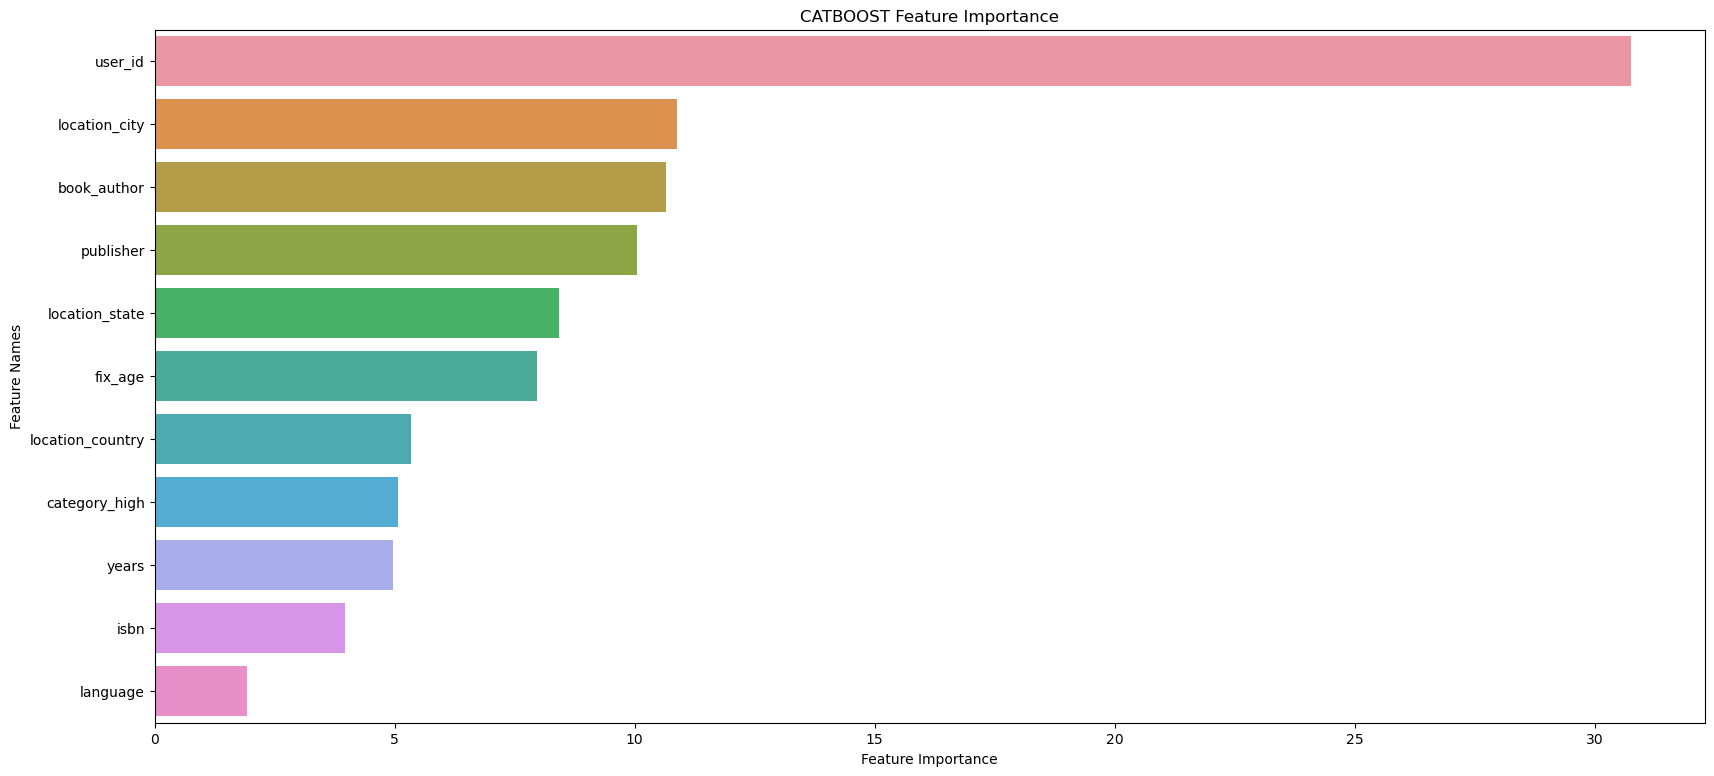

In [128]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')